In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import scipy.signal


# Librerías para Clustering
from sklearn.cluster import KMeans, DBSCAN #importamos kmeans y dbsac de la libreria de clustering de sklearn
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, rand_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_auc_score,
                             make_scorer,
                             accuracy_score,
                             classification_report,
                             roc_curve,
                             f1_score,
                             matthews_corrcoef,
                             precision_score,  # ESTE ES EL QUE USE HASTA EL MOMENTO
                             recall_score,
                             confusion_matrix)

In [2]:
from Utils import scan_folders

In [3]:
#Elección de Ejes
def plot_unsup(df_raw_data, model_name = " ", df_name=" "):
    

    #Elección de Ejes
    etiq = "etiqueta"
    clust = "Etiqueta_k"
    corr_df = df_raw_data.corr()[clust] #calculamos la correlacion
    columns = corr_df.index.values #sacamos los valores que participan en la correlacion (las columnas del df)
    corrs = abs(corr_df.values) #obtenemos los valores de la correlacion
    indexes = corrs.argsort() #argsort da los indices del arreglo ordenados para que los valores queden de menor a mayor
    #print(columns)
    #print(corrs)
    #print(indexes)
    for i in range(indexes.shape[0]-1, -1, -1): #recorremos los indices de arriba hacia abajo (ya que se ordenan de manera creciente)
        if columns[indexes[i]] != etiq and columns[indexes[i]] != clust: #el mayor indice que no sea la columna de clusters ni la de etiquetas es el primer eje
            Eje1Pos = indexes[i]
            Eje1 = columns[Eje1Pos]
            break
    for i in range(indexes.shape[0]-1, -1, -1): #el mayor indice que no sea la columna de clusters ni la de etiquetas ni la del primer eje es el segundo eje
        if columns[indexes[i]] != etiq and columns[indexes[i]] != clust and columns[indexes[i]] != Eje1:
            Eje2Pos = indexes[i]
            Eje2 = columns[Eje2Pos]
            break
    #print(Eje1)
    #print(Eje1Pos)
    #print(Eje2)
    #print(Eje2Pos)
    etiq_colors = ["white","black", "yellow","green","orange","pink","black","orange","pink"]
    clust_colors = ["blue", "green", "red","purple","grey","blue"]
    # a transformarse por los dos mas representativos o de mas peso 

    #ploteo
    fig, axs = plt.subplots(1,1)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for cl in df_raw_data[clust].unique():
        temp_df = df_raw_data.loc[df_raw_data[clust]==cl]
        axs.scatter(temp_df[Eje1],temp_df[Eje2], s=5000, alpha = 0.3, color = clust_colors[cl])
    for et in df_raw_data[etiq].unique():
        temp_df = df_raw_data.loc[df_raw_data[etiq]==et]
        axs.scatter(temp_df[Eje1],temp_df[Eje2], color = etiq_colors[et], label='etiqueta'+str(et))

    axs.set_xlabel(Eje1)
    axs.set_ylabel(Eje2)
    

    axs.set_title("Etiquetas vs Clusters" + model_name +"_"+ df_name,fontsize = 12)
    axs.legend()
    fig.show()
    
    
    spath = "C:/Users/toto_/PYTHON_TESIS/GRAPH_NOSUP/GRAPH_NOSUP_3"
    fig.savefig(spath+"/"+str(model_name) +"+"+ str(df_name)+".jpg")


    return 

In [4]:
def comparision_results_unsup(df_raw_data,n_etiqueta,n_clusters,model_name = " ", df_name=" "):
    
    #Ene ste bloque genero la tabla vacia a completar
    matrix = np.zeros((n_etiqueta.shape[0], n_clusters.shape[0]))
    count_kmeans= pd.DataFrame(matrix, index=list(n_etiqueta), columns=list(n_clusters))


    for fila in range(df_raw_data.shape[0]):
        count_kmeans.loc[int(df_raw_data.loc[fila,["etiqueta"]]),int(df_raw_data.loc[fila,["Etiqueta_k"]])] +=1
        
    #normalizador de contador  
    
    #En esta parte se obtienen los denominadores comunes 
    lista_denom=[]
    for fila in count_kmeans.index:
        denominador=0
        for columna in range(count_kmeans.shape[1]):

            denominador= denominador + int(count_kmeans.loc[fila,columna])

        if lista_denom is None:
            lista_denom = denominador

        else:       
            lista_denom = np.append(lista_denom, denominador)
    
    #En esta parte se genera la tabla con los resultados
    i=0
    count_kmeans_nor=count_kmeans.copy()

    for fila in count_kmeans.index:
        lista= lista_denom[i]
        #print("denominador:", lista)

        for columna in range(count_kmeans.shape[1]): 
            #print("lugar:", fila , columna, count_kmeans.loc[fila,columna] )

            if count_kmeans.loc[fila,columna] > 0:
                valor_n=((int(count_kmeans.loc[fila,columna])/lista))
            else:
                valor_n = 0
            #print("valor_n:", valor_n)
            count_kmeans_nor.loc[fila,columna] = valor_n
        i=i+1
    
    count_kmeans_nor = pd.DataFrame.from_dict(count_kmeans_nor)
    count_kmeans = pd.DataFrame.from_dict(count_kmeans)
    
    print(count_kmeans_nor)
    print(count_kmeans)
    

    #with pd.ExcelWriter('unsuppervised_models_outputs 3.xlsx', mode="a", engine="openpyxl") as writer:  
    #    count_kmeans.to_excel(writer, sheet_name= model_name +"+"+ df_name)
    
    with pd.ExcelWriter('unsuppervised_models_outputs_Normalizados 3.xlsx', mode="a", engine="openpyxl") as writer: 
        count_kmeans_nor.to_excel(writer, sheet_name= model_name +"+"+ df_name )
    
    
    return count_kmeans_nor, count_kmeans
    #return count_kmeans_nor

In [5]:
def supervised_training_models(dataframe,score_sup, model, model_name = " ", df_name=" "):
    X = dataframe.drop(['etiqueta'], axis=1).values #lo que hace aca es guardar en x mi dataframe pero sin la columna label o etiqueta que es lo que estamos tratando de predecir. y elVALUES lo que hace es pasarme los datos de datafrme a numpy array.
    y = dataframe.etiqueta
    
    X_train,X_test,  y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3, #OJO CON ESTO, PORQUE ESTOY DEFINIENDO LO MISMO PARA TODOS LOS MODELOS
                                                        stratify=y,#lo que hace esto es que quede la misma proporcion de 0 y 1 de los label en train y test y  no lo haga tan random
                                                        random_state=123) #puedo definir una semilla de ranodm para que si despues viene otro y lo corre no le tire otro random

    model.fit(X_train, y_train)
    
    y_pred_test = model.predict(X_test)
    
    score = classification_report(y_test,y_pred_test, output_dict=True)
    df_score = pd.DataFrame(score).transpose()
    print(df_score)
    
    score_sup.loc[df_name,model_name] = df_score.loc["macro avg","f1-score"]
    
    df_score_et = df_score.iloc[:-3,:]
    
    
    #MATRIZ DE CONFUSIÓN
    
    cnf_matrix = confusion_matrix(y_test, y_pred_test, normalize= "true")
    cnf_matrix  = pd.DataFrame(cnf_matrix,index=df_score_et.index.values,columns=df_score_et.index.values)
    cnf_matrix  = pd.DataFrame(cnf_matrix,index=df_score_et.index.values,columns=df_score_et.index.values)
    Img_matrix=sn.heatmap(cnf_matrix,cmap="YlOrRd", annot=True, xticklabels=df_score_et.index.values , yticklabels=df_score_et.index.values)
    plt.title('Matriz de confusión '+ str(model_name) +"+"+ str(df_name), fontsize = 12) # title with fontsize 
    plt.show()
    
    figure = Img_matrix.get_figure()
    spath = "C:/Users/toto_/PYTHON_TESIS/MATRIX_CNF/MATRIX_CNF_3"
    figure.savefig(spath+"/"+str(model_name) +"+"+ str(df_name)+".jpg")
    
    with pd.ExcelWriter('matriz_confusion_3.xlsx', mode="a", engine="openpyxl") as writer:            
        cnf_matrix.to_excel(writer, sheet_name='Score'+ model_name +"+"+ df_name)
    
    
    with pd.ExcelWriter('Classification_report_3_etiquetas.xlsx', mode="a", engine="openpyxl") as writer:            
        df_score.to_excel(writer, sheet_name='Score'+ model_name +"+"+ df_name)


    return model, score, df_score , score_sup


In [6]:
def unsupervised_training_models(dataframe,score_unsup, model, model_name = " ", df_name=" "):
    #preparacion
    n_etiqueta = dataframe['etiqueta'].unique()
    X = dataframe.drop(['etiqueta'], axis=1)
    y = dataframe.etiqueta.values #vector con las etiquetas
    
    #entrenamiento
    model.fit(X)
    
    Prediction = model.predict(X)
    n_clusters=np.unique(Prediction)
    dataframe.insert(0, "Etiqueta_k", Prediction) #COLUMNA DE PREDICCIÓN
    print("n_clusters", n_clusters)
    
    graph_nosup = plot_unsup(dataframe,str(model_name),str(df_name)) 
        
    RS=rand_score(y,Prediction)
    ARS=adjusted_rand_score(y, Prediction)
    print(RS)
    score_unsup.loc[df_name,model_name] = RS
  
    count_kmeans_nor, count_kmeans = comparision_results_unsup(dataframe,n_etiqueta,n_clusters,str(model_name),str(df_name))
    
    
    return model, count_kmeans_nor, count_kmeans, score_unsup
    #return model, score_unsup

In [7]:
#BLOQUE DE DATAFRAMES 

main_path = "C:/Users/toto_/PYTHON_TESIS/Dataframe_Classifier/Dataframe_Classifier_3"

list_df = scan_folders(main_path,extension =".xlsx")


list_df

#print(list_df[0][0])
#print(list_df[0][1])
n_df=len(list_df)
print(n_df)
my_list=[]

for fila in range (len(list_df)):
    my_list.append(list_df[fila][1])
print(my_list)

In [8]:
#BLOQUE DE MODELOS

#Modelos No supervisados 
km4=KMeans(n_clusters =4 , init = 'k-means++',max_iter = 300, n_init = 10)
km3=KMeans(n_clusters =3 , init = 'k-means++',max_iter = 300, n_init = 10)
#dbscan = DBSCAN(eps=0.4, min_samples=5)


#Modelos supervisados
kn3 = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)
linear_svc = svm.SVC(kernel='linear',C=100, class_weight='balanced')
rforest = RandomForestClassifier(n_estimators = 100, max_depth = 10, class_weight = 'balanced') #OJO VARIA RESULTADO EN CADA CORRIDA


datarame N°: df_mix_dos.xlsx
model KmC4
          min       max       std  AMPLITUD ONDA B FILT.  \
0    0.333366  0.015322 -0.089710               0.245408   
1    0.242211  0.098394 -0.018877               0.255094   
2   -0.418959  1.105769  1.011489               0.393777   
3   -0.300300  0.382823  0.596810               0.254751   
4   -2.900485  2.502953  3.157765               0.631879   
..        ...       ...       ...                    ...   
164  1.107195 -0.838128 -0.911431               0.116198   
165  0.250275 -1.121410 -0.767125               0.208037   
166  0.412712 -1.155641 -0.854059               0.205093   
167  0.783618 -0.576171 -0.634329               0.207628   
168  0.868341 -0.595235 -0.635102               0.191533   

     LATENCIA ONDA B FILT.  PENDIENTE AB  etiqueta  
0                 0.645390      0.190702         0  
1                 0.645390      0.197522         0  
2                 0.556738      0.286526         0  
3                 0.464539 

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6211608903916597
          0         1         2         3
0  0.087912  0.340659  0.406593  0.164835
1  0.333333  0.133333  0.533333  0.000000
2  0.746032  0.000000  0.253968  0.000000
      0     1     2     3
0   8.0  31.0  37.0  15.0
1   5.0   2.0   8.0   0.0
2  47.0   0.0  16.0   0.0
model KmC3
          min       max       std  AMPLITUD ONDA B FILT.  \
0    0.333366  0.015322 -0.089710               0.245408   
1    0.242211  0.098394 -0.018877               0.255094   
2   -0.418959  1.105769  1.011489               0.393777   
3   -0.300300  0.382823  0.596810               0.254751   
4   -2.900485  2.502953  3.157765               0.631879   
..        ...       ...       ...                    ...   
164  1.107195 -0.838128 -0.911431               0.116198   
165  0.250275 -1.121410 -0.767125               0.208037   
166  0.412712 -1.155641 -0.854059               0.205093   
167  0.783618 -0.576171 -0.634329               0.207628   
168  0.868341 -0.595235 -0.635102     

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6179909833755988
          0         1         2
0  0.241758  0.252747  0.505495
1  0.400000  0.066667  0.533333
2  0.904762  0.000000  0.095238
      0     1     2
0  22.0  23.0  46.0
1   6.0   1.0   8.0
2  57.0   0.0   6.0
datarame N°: df_mix_uno.xlsx
model KmC4
          min       max       std    energy  AMPLITUD ONDA B FILT.  \
0    0.333366  0.015322 -0.089710 -0.289680               0.245408   
1    0.242211  0.098394 -0.018877 -0.240977               0.255094   
2   -0.418959  1.105769  1.011489  0.720702               0.393777   
3   -0.300300  0.382823  0.596810  0.274762               0.254751   
4   -2.900485  2.502953  3.157765  4.275857               0.631879   
..        ...       ...       ...       ...                    ...   
164  1.107195 -0.838128 -0.911431 -0.685505               0.116198   
165  0.250275 -1.121410 -0.767125 -0.638139               0.208037   
166  0.412712 -1.155641 -0.854059 -0.667660               0.205093   
167  0.783618 -0.576171 -0.634329

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6222175260636799
          0         1         2         3
0  0.351648  0.406593  0.087912  0.153846
1  0.133333  0.533333  0.333333  0.000000
2  0.000000  0.253968  0.746032  0.000000
      0     1     2     3
0  32.0  37.0   8.0  14.0
1   2.0   8.0   5.0   0.0
2   0.0  16.0  47.0   0.0
model KmC3
          min       max       std    energy  AMPLITUD ONDA B FILT.  \
0    0.333366  0.015322 -0.089710 -0.289680               0.245408   
1    0.242211  0.098394 -0.018877 -0.240977               0.255094   
2   -0.418959  1.105769  1.011489  0.720702               0.393777   
3   -0.300300  0.382823  0.596810  0.274762               0.254751   
4   -2.900485  2.502953  3.157765  4.275857               0.631879   
..        ...       ...       ...       ...                    ...   
164  1.107195 -0.838128 -0.911431 -0.685505               0.116198   
165  0.250275 -1.121410 -0.767125 -0.638139               0.208037   
166  0.412712 -1.155641 -0.854059 -0.667660               0.205093  

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6051000281769513
          0         1         2
0  0.494505  0.318681  0.186813
1  0.533333  0.466667  0.000000
2  0.031746  0.968254  0.000000
      0     1     2
0  45.0  29.0  17.0
1   8.0   7.0   0.0
2   2.0  61.0   0.0
datarame N°: stats_df_cinco.xlsx
model KmC4
         mean       min       std  etiqueta
0   -0.573769  0.333366 -0.089710         0
1   -0.672474  0.242211 -0.018877         0
2   -0.652334 -0.418959  1.011489         0
3   -0.355042 -0.300300  0.596810         0
4   -1.089536 -2.900485  3.157765         0
..        ...       ...       ...       ...
164  0.253094  1.107195 -0.911431         2
165 -0.143364  0.250275 -0.767125         2
166 -0.119483  0.412712 -0.854059         2
167  0.964187  0.783618 -0.634329         2
168  1.107095  0.868341 -0.635102         2

[169 rows x 4 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5955903071287687
          0         1        2         3
0  0.296703  0.197802  0.21978  0.285714
1  0.333333  0.133333  0.00000  0.533333
2  0.047619  0.761905  0.00000  0.190476
      0     1     2     3
0  27.0  18.0  20.0  26.0
1   5.0   2.0   0.0   8.0
2   3.0  48.0   0.0  12.0
model KmC3
         mean       min       std  etiqueta
0   -0.573769  0.333366 -0.089710         0
1   -0.672474  0.242211 -0.018877         0
2   -0.652334 -0.418959  1.011489         0
3   -0.355042 -0.300300  0.596810         0
4   -1.089536 -2.900485  3.157765         0
..        ...       ...       ...       ...
164  0.253094  1.107195 -0.911431         2
165 -0.143364  0.250275 -0.767125         2
166 -0.119483  0.412712 -0.854059         2
167  0.964187  0.783618 -0.634329         2
168  1.107095  0.868341 -0.635102         2

[169 rows x 4 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5786841363764441
          0         1         2
0  0.208791  0.461538  0.329670
1  0.000000  0.533333  0.466667
2  0.000000  0.095238  0.904762
      0     1     2
0  19.0  42.0  30.0
1   0.0   8.0   7.0
2   0.0   6.0  57.0
datarame N°: stats_df_cuatro.xlsx
model KmC4
          min       max       std    energy  etiqueta
0    0.333366  0.015322 -0.089710 -0.289680         0
1    0.242211  0.098394 -0.018877 -0.240977         0
2   -0.418959  1.105769  1.011489  0.720702         0
3   -0.300300  0.382823  0.596810  0.274762         0
4   -2.900485  2.502953  3.157765  4.275857         0
..        ...       ...       ...       ...       ...
164  1.107195 -0.838128 -0.911431 -0.685505         2
165  0.250275 -1.121410 -0.767125 -0.638139         2
166  0.412712 -1.155641 -0.854059 -0.667660         2
167  0.783618 -0.576171 -0.634329 -0.585863         2
168  0.868341 -0.595235 -0.635102 -0.585782         2

[169 rows x 5 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6101014370245139
          0         1         2         3
0  0.351648  0.120879  0.153846  0.373626
1  0.133333  0.400000  0.000000  0.466667
2  0.000000  0.746032  0.000000  0.253968
      0     1     2     3
0  32.0  11.0  14.0  34.0
1   2.0   6.0   0.0   7.0
2   0.0  47.0   0.0  16.0
model KmC3
          min       max       std    energy  etiqueta
0    0.333366  0.015322 -0.089710 -0.289680         0
1    0.242211  0.098394 -0.018877 -0.240977         0
2   -0.418959  1.105769  1.011489  0.720702         0
3   -0.300300  0.382823  0.596810  0.274762         0
4   -2.900485  2.502953  3.157765  4.275857         0
..        ...       ...       ...       ...       ...
164  1.107195 -0.838128 -0.911431 -0.685505         2
165  0.250275 -1.121410 -0.767125 -0.638139         2
166  0.412712 -1.155641 -0.854059 -0.667660         2
167  0.783618 -0.576171 -0.634329 -0.585863         2
168  0.868341 -0.595235 -0.635102 -0.585782         2

[169 rows x 5 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6051000281769513
          0         1         2
0  0.494505  0.318681  0.186813
1  0.533333  0.466667  0.000000
2  0.031746  0.968254  0.000000
      0     1     2
0  45.0  29.0  17.0
1   8.0   7.0   0.0
2   2.0  61.0   0.0
datarame N°: stats_df_diez.xlsx
model KmC4
         mean       std  etiqueta
0   -0.573769 -0.089710         0
1   -0.672474 -0.018877         0
2   -0.652334  1.011489         0
3   -0.355042  0.596810         0
4   -1.089536  3.157765         0
..        ...       ...       ...
164  0.253094 -0.911431         2
165 -0.143364 -0.767125         2
166 -0.119483 -0.854059         2
167  0.964187 -0.634329         2
168  1.107095 -0.635102         2

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.595519864750634
          0         1         2         3
0  0.230769  0.186813  0.307692  0.274725
1  0.266667  0.000000  0.200000  0.533333
2  0.825397  0.000000  0.000000  0.174603
      0     1     2     3
0  21.0  17.0  28.0  25.0
1   4.0   0.0   3.0   8.0
2  52.0   0.0   0.0  11.0
model KmC3
         mean       std  etiqueta
0   -0.573769 -0.089710         0
1   -0.672474 -0.018877         0
2   -0.652334  1.011489         0
3   -0.355042  0.596810         0
4   -1.089536  3.157765         0
..        ...       ...       ...
164  0.253094 -0.911431         2
165 -0.143364 -0.767125         2
166 -0.119483 -0.854059         2
167  0.964187 -0.634329         2
168  1.107095 -0.635102         2

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5756551141166526
          0         1         2
0  0.373626  0.274725  0.351648
1  0.533333  0.133333  0.333333
2  0.968254  0.031746  0.000000
      0     1     2
0  34.0  25.0  32.0
1   8.0   2.0   5.0
2  61.0   2.0   0.0
datarame N°: stats_df_dos.xlsx
model KmC4
          min       max       std  etiqueta
0    0.333366  0.015322 -0.089710         0
1    0.242211  0.098394 -0.018877         0
2   -0.418959  1.105769  1.011489         0
3   -0.300300  0.382823  0.596810         0
4   -2.900485  2.502953  3.157765         0
..        ...       ...       ...       ...
164  1.107195 -0.838128 -0.911431         2
165  0.250275 -1.121410 -0.767125         2
166  0.412712 -1.155641 -0.854059         2
167  0.783618 -0.576171 -0.634329         2
168  0.868341 -0.595235 -0.635102         2

[169 rows x 4 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6211608903916597
          0         1         2         3
0  0.340659  0.087912  0.164835  0.406593
1  0.133333  0.333333  0.000000  0.533333
2  0.000000  0.746032  0.000000  0.253968
      0     1     2     3
0  31.0   8.0  15.0  37.0
1   2.0   5.0   0.0   8.0
2   0.0  47.0   0.0  16.0
model KmC3
          min       max       std  etiqueta
0    0.333366  0.015322 -0.089710         0
1    0.242211  0.098394 -0.018877         0
2   -0.418959  1.105769  1.011489         0
3   -0.300300  0.382823  0.596810         0
4   -2.900485  2.502953  3.157765         0
..        ...       ...       ...       ...
164  1.107195 -0.838128 -0.911431         2
165  0.250275 -1.121410 -0.767125         2
166  0.412712 -1.155641 -0.854059         2
167  0.783618 -0.576171 -0.634329         2
168  0.868341 -0.595235 -0.635102         2

[169 rows x 4 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6129191321499013
          0         1         2
0  0.494505  0.252747  0.252747
1  0.533333  0.400000  0.066667
2  0.095238  0.904762  0.000000
      0     1     2
0  45.0  23.0  23.0
1   8.0   6.0   1.0
2   6.0  57.0   0.0
datarame N°: stats_df_nueve.xlsx
model KmC4
          std    energy  etiqueta
0   -0.089710 -0.289680         0
1   -0.018877 -0.240977         0
2    1.011489  0.720702         0
3    0.596810  0.274762         0
4    3.157765  4.275857         0
..        ...       ...       ...
164 -0.911431 -0.685505         2
165 -0.767125 -0.638139         2
166 -0.854059 -0.667660         2
167 -0.634329 -0.585863         2
168 -0.635102 -0.585782         2

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6241899126514511
          0         1         2         3
0  0.351648  0.153846  0.384615  0.109890
1  0.600000  0.000000  0.133333  0.266667
2  0.238095  0.000000  0.000000  0.761905
      0     1     2     3
0  32.0  14.0  35.0  10.0
1   9.0   0.0   2.0   4.0
2  15.0   0.0   0.0  48.0
model KmC3
          std    energy  etiqueta
0   -0.089710 -0.289680         0
1   -0.018877 -0.240977         0
2    1.011489  0.720702         0
3    0.596810  0.274762         0
4    3.157765  4.275857         0
..        ...       ...       ...
164 -0.911431 -0.685505         2
165 -0.767125 -0.638139         2
166 -0.854059 -0.667660         2
167 -0.634329 -0.585863         2
168 -0.635102 -0.585782         2

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5965060580445196
          0         1         2
0  0.461538  0.351648  0.186813
1  0.466667  0.533333  0.000000
2  0.000000  1.000000  0.000000
      0     1     2
0  42.0  32.0  17.0
1   7.0   8.0   0.0
2   0.0  63.0   0.0
datarame N°: stats_df_ocho.xlsx
model KmC4
          min       std  etiqueta
0    0.333366 -0.089710         0
1    0.242211 -0.018877         0
2   -0.418959  1.011489         0
3   -0.300300  0.596810         0
4   -2.900485  3.157765         0
..        ...       ...       ...
164  1.107195 -0.911431         2
165  0.250275 -0.767125         2
166  0.412712 -0.854059         2
167  0.783618 -0.634329         2
168  0.868341 -0.635102         2

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6061566638489715
          0         1         2         3
0  0.406593  0.307692  0.153846  0.131868
1  0.133333  0.466667  0.400000  0.000000
2  0.222222  0.015873  0.761905  0.000000
      0     1     2     3
0  37.0  28.0  14.0  12.0
1   2.0   7.0   6.0   0.0
2  14.0   1.0  48.0   0.0
model KmC3
          min       std  etiqueta
0    0.333366 -0.089710         0
1    0.242211 -0.018877         0
2   -0.418959  1.011489         0
3   -0.300300  0.596810         0
4   -2.900485  3.157765         0
..        ...       ...       ...
164  1.107195 -0.911431         2
165  0.250275 -0.767125         2
166  0.412712 -0.854059         2
167  0.783618 -0.634329         2
168  0.868341 -0.635102         2

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5796703296703297
          0         1         2
0  0.263736  0.307692  0.428571
1  0.000000  0.400000  0.600000
2  0.000000  0.873016  0.126984
      0     1     2
0  24.0  28.0  39.0
1   0.0   6.0   9.0
2   0.0  55.0   8.0
datarame N°: stats_df_seis.xlsx
model KmC4
         mean       max       std  etiqueta
0   -0.573769  0.015322 -0.089710         0
1   -0.672474  0.098394 -0.018877         0
2   -0.652334  1.105769  1.011489         0
3   -0.355042  0.382823  0.596810         0
4   -1.089536  2.502953  3.157765         0
..        ...       ...       ...       ...
164  0.253094 -0.838128 -0.911431         2
165 -0.143364 -1.121410 -0.767125         2
166 -0.119483 -1.155641 -0.854059         2
167  0.964187 -0.576171 -0.634329         2
168  1.107095 -0.595235 -0.635102         2

[169 rows x 4 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6228515074668921
          0         1        2         3
0  0.296703  0.186813  0.32967  0.186813
1  0.533333  0.000000  0.20000  0.266667
2  0.126984  0.000000  0.00000  0.873016
      0     1     2     3
0  27.0  17.0  30.0  17.0
1   8.0   0.0   3.0   4.0
2   8.0   0.0   0.0  55.0
model KmC3
         mean       max       std  etiqueta
0   -0.573769  0.015322 -0.089710         0
1   -0.672474  0.098394 -0.018877         0
2   -0.652334  1.105769  1.011489         0
3   -0.355042  0.382823  0.596810         0
4   -1.089536  2.502953  3.157765         0
..        ...       ...       ...       ...
164  0.253094 -0.838128 -0.911431         2
165 -0.143364 -1.121410 -0.767125         2
166 -0.119483 -1.155641 -0.854059         2
167  0.964187 -0.576171 -0.634329         2
168  1.107095 -0.595235 -0.635102         2

[169 rows x 4 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5712172442941674
          0         1         2
0  0.296703  0.340659  0.362637
1  0.133333  0.200000  0.666667
2  0.031746  0.000000  0.968254
      0     1     2
0  27.0  31.0  33.0
1   2.0   3.0  10.0
2   2.0   0.0  61.0
datarame N°: stats_df_siete.xlsx
model KmC4
          max       std  etiqueta
0    0.015322 -0.089710         0
1    0.098394 -0.018877         0
2    1.105769  1.011489         0
3    0.382823  0.596810         0
4    2.502953  3.157765         0
..        ...       ...       ...
164 -0.838128 -0.911431         2
165 -1.121410 -0.767125         2
166 -1.155641 -0.854059         2
167 -0.576171 -0.634329         2
168 -0.595235 -0.635102         2

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6450408565793181
          0         1         2         3
0  0.197802  0.076923  0.373626  0.351648
1  0.066667  0.333333  0.133333  0.466667
2  0.000000  0.793651  0.000000  0.206349
      0     1     2     3
0  18.0   7.0  34.0  32.0
1   1.0   5.0   2.0   7.0
2   0.0  50.0   0.0  13.0
model KmC3
          max       std  etiqueta
0    0.015322 -0.089710         0
1    0.098394 -0.018877         0
2    1.105769  1.011489         0
3    0.382823  0.596810         0
4    2.502953  3.157765         0
..        ...       ...       ...
164 -0.838128 -0.911431         2
165 -1.121410 -0.767125         2
166 -1.155641 -0.854059         2
167 -0.576171 -0.634329         2
168 -0.595235 -0.635102         2

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6631445477599324
          0         1         2
0  0.571429  0.098901  0.329670
1  0.600000  0.333333  0.066667
2  0.158730  0.841270  0.000000
      0     1     2
0  52.0   9.0  30.0
1   9.0   5.0   1.0
2  10.0  53.0   0.0
datarame N°: stats_df_tres.xlsx
model KmC4
         mean       min       max       std  etiqueta
0   -0.573769  0.333366  0.015322 -0.089710         0
1   -0.672474  0.242211  0.098394 -0.018877         0
2   -0.652334 -0.418959  1.105769  1.011489         0
3   -0.355042 -0.300300  0.382823  0.596810         0
4   -1.089536 -2.900485  2.502953  3.157765         0
..        ...       ...       ...       ...       ...
164  0.253094  1.107195 -0.838128 -0.911431         2
165 -0.143364  0.250275 -1.121410 -0.767125         2
166 -0.119483  0.412712 -1.155641 -0.854059         2
167  0.964187  0.783618 -0.576171 -0.634329         2
168  1.107095  0.868341 -0.595235 -0.635102         2

[169 rows x 5 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,1)
<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6100309946463792
          0        1         2         3
0  0.307692  0.21978  0.131868  0.340659
1  0.200000  0.00000  0.133333  0.666667
2  0.000000  0.00000  0.746032  0.253968
      0     1     2     3
0  28.0  20.0  12.0  31.0
1   3.0   0.0   2.0  10.0
2   0.0   0.0  47.0  16.0
model KmC3
         mean       min       max       std  etiqueta
0   -0.573769  0.333366  0.015322 -0.089710         0
1   -0.672474  0.242211  0.098394 -0.018877         0
2   -0.652334 -0.418959  1.105769  1.011489         0
3   -0.355042 -0.300300  0.382823  0.596810         0
4   -1.089536 -2.900485  2.502953  3.157765         0
..        ...       ...       ...       ...       ...
164  0.253094  1.107195 -0.838128 -0.911431         2
165 -0.143364  0.250275 -1.121410 -0.767125         2
166 -0.119483  0.412712 -1.155641 -0.854059         2
167  0.964187  0.783618 -0.576171 -0.634329         2
168  1.107095  0.868341 -0.595235 -0.635102         2

[169 rows x 5 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5929839391377852
          0         1         2
0  0.340659  0.208791  0.450549
1  0.466667  0.000000  0.533333
2  0.968254  0.000000  0.031746
      0     1     2
0  31.0  19.0  41.0
1   7.0   0.0   8.0
2  61.0   0.0   2.0
datarame N°: stats_df_uno.xlsx
model KmC4
         mean       min       max       std    energy  etiqueta
0   -0.573769  0.333366  0.015322 -0.089710 -0.289680         0
1   -0.672474  0.242211  0.098394 -0.018877 -0.240977         0
2   -0.652334 -0.418959  1.105769  1.011489  0.720702         0
3   -0.355042 -0.300300  0.382823  0.596810  0.274762         0
4   -1.089536 -2.900485  2.502953  3.157765  4.275857         0
..        ...       ...       ...       ...       ...       ...
164  0.253094  1.107195 -0.838128 -0.911431 -0.685505         2
165 -0.143364  0.250275 -1.121410 -0.767125 -0.638139         2
166 -0.119483  0.412712 -1.155641 -0.854059 -0.667660         2
167  0.964187  0.783618 -0.576171 -0.634329 -0.585863         2
168  1.107095  0.868341 -0.

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5899549168779938
          0         1         2         3
0  0.296703  0.131868  0.263736  0.307692
1  0.400000  0.000000  0.133333  0.466667
2  0.936508  0.000000  0.000000  0.063492
      0     1     2     3
0  27.0  12.0  24.0  28.0
1   6.0   0.0   2.0   7.0
2  59.0   0.0   0.0   4.0
model KmC3
         mean       min       max       std    energy  etiqueta
0   -0.573769  0.333366  0.015322 -0.089710 -0.289680         0
1   -0.672474  0.242211  0.098394 -0.018877 -0.240977         0
2   -0.652334 -0.418959  1.105769  1.011489  0.720702         0
3   -0.355042 -0.300300  0.382823  0.596810  0.274762         0
4   -1.089536 -2.900485  2.502953  3.157765  4.275857         0
..        ...       ...       ...       ...       ...       ...
164  0.253094  1.107195 -0.838128 -0.911431 -0.685505         2
165 -0.143364  0.250275 -1.121410 -0.767125 -0.638139         2
166 -0.119483  0.412712 -1.155641 -0.854059 -0.667660         2
167  0.964187  0.783618 -0.576171 -0.634329 -0.585863     

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6008734854888701
          0         1         2
0  0.494505  0.362637  0.142857
1  0.533333  0.466667  0.000000
2  0.000000  1.000000  0.000000
      0     1     2
0  45.0  33.0  13.0
1   8.0   7.0   0.0
2   0.0  63.0   0.0
datarame N°: wave_df_cinco.xlsx
model KmC4
     AMPLITUD ONDA B FILT.  AMPLITUD ONDA A FILT.  PENDIENTE AB  etiqueta
0                 0.245408               0.341063      0.190702         0
1                 0.255094               0.356684      0.197522         0
2                 0.393777               0.261962      0.286526         0
3                 0.254751               0.401809      0.397147         0
4                 0.631879               0.528046      0.525183         0
..                     ...                    ...           ...       ...
164               0.116198               0.183700      0.088031         2
165               0.208037               0.025261      0.048657         2
166               0.205093               0.040668      0.050438 

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6437024513947591
          0         1         2        3
0  0.296703  0.131868  0.351648  0.21978
1  0.333333  0.466667  0.200000  0.00000
2  0.111111  0.888889  0.000000  0.00000
      0     1     2     3
0  27.0  12.0  32.0  20.0
1   5.0   7.0   3.0   0.0
2   7.0  56.0   0.0   0.0
model KmC3
     AMPLITUD ONDA B FILT.  AMPLITUD ONDA A FILT.  PENDIENTE AB  etiqueta
0                 0.245408               0.341063      0.190702         0
1                 0.255094               0.356684      0.197522         0
2                 0.393777               0.261962      0.286526         0
3                 0.254751               0.401809      0.397147         0
4                 0.631879               0.528046      0.525183         0
..                     ...                    ...           ...       ...
164               0.116198               0.183700      0.088031         2
165               0.208037               0.025261      0.048657         2
166               0.205093          

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6584953508030431
          0         1         2
0  0.208791  0.549451  0.241758
1  0.666667  0.266667  0.066667
2  0.984127  0.015873  0.000000
      0     1     2
0  19.0  50.0  22.0
1  10.0   4.0   1.0
2  62.0   1.0   0.0
datarame N°: wave_df_cuatro.xlsx
model KmC4
     AMPLITUD ONDA B FILT.  PENDIENTE AB  etiqueta
0                 0.245408      0.190702         0
1                 0.255094      0.197522         0
2                 0.393777      0.286526         0
3                 0.254751      0.397147         0
4                 0.631879      0.525183         0
..                     ...           ...       ...
164               0.116198      0.088031         2
165               0.208037      0.048657         2
166               0.205093      0.050438         2
167               0.207628      0.111979         2
168               0.191533      0.095914         2

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6501127078050155
          0         1         2         3
0  0.461538  0.076923  0.219780  0.241758
1  0.266667  0.400000  0.066667  0.266667
2  0.000000  0.746032  0.000000  0.253968
      0     1     2     3
0  42.0   7.0  20.0  22.0
1   4.0   6.0   1.0   4.0
2   0.0  47.0   0.0  16.0
model KmC3
     AMPLITUD ONDA B FILT.  PENDIENTE AB  etiqueta
0                 0.245408      0.190702         0
1                 0.255094      0.197522         0
2                 0.393777      0.286526         0
3                 0.254751      0.397147         0
4                 0.631879      0.525183         0
..                     ...           ...       ...
164               0.116198      0.088031         2
165               0.208037      0.048657         2
166               0.205093      0.050438         2
167               0.207628      0.111979         2
168               0.191533      0.095914         2

[169 rows x 3 columns]


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6500422654268808
          0         1         2
0  0.208791  0.571429  0.219780
1  0.666667  0.266667  0.066667
2  0.952381  0.047619  0.000000
      0     1     2
0  19.0  52.0  20.0
1  10.0   4.0   1.0
2  60.0   3.0   0.0
datarame N°: wave_df_dos.xlsx
model KmC4
     LATENCIA ONDA B  AMPLITUD ONDA B  ANCHO ONDA B  LATENCIA ONDA A  \
0           0.622378         0.306643      0.712617         0.403509   
1           0.622378         0.333144      0.701994         0.403509   
2           0.576923         0.571029      0.720466         0.327485   
3           0.510490         0.351565      0.743069         0.397661   
4           0.412587         0.743059      0.878371         0.245614   
..               ...              ...           ...              ...   
164         0.534965         0.123091      0.698020         0.555556   
165         0.311189         0.114917      0.819111         0.111111   
166         0.307692         0.099042      0.833159         0.105263   
167         

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5806565229642153
          0         1         2         3
0  0.197802  0.010989  0.472527  0.318681
1  0.000000  0.333333  0.133333  0.533333
2  0.396825  0.158730  0.079365  0.365079
      0     1     2     3
0  18.0   1.0  43.0  29.0
1   0.0   5.0   2.0   8.0
2  25.0  10.0   5.0  23.0
model KmC3
     LATENCIA ONDA B  AMPLITUD ONDA B  ANCHO ONDA B  LATENCIA ONDA A  \
0           0.622378         0.306643      0.712617         0.403509   
1           0.622378         0.333144      0.701994         0.403509   
2           0.576923         0.571029      0.720466         0.327485   
3           0.510490         0.351565      0.743069         0.397661   
4           0.412587         0.743059      0.878371         0.245614   
..               ...              ...           ...              ...   
164         0.534965         0.123091      0.698020         0.555556   
165         0.311189         0.114917      0.819111         0.111111   
166         0.307692         0.099042      0.83315

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6213722175260636
          0         1         2
0  0.230769  0.747253  0.021978
1  0.066667  0.466667  0.466667
2  0.539683  0.238095  0.222222
      0     1     2
0  21.0  68.0   2.0
1   1.0   7.0   7.0
2  34.0  15.0  14.0
datarame N°: wave_df_ocho.xlsx
model KmC4
     AMPLITUD ONDA A FILT.  LATENCIA ONDA A FILT.  ANCHO ONDA A FILT.  \
0                 0.341063               0.305164            0.426210   
1                 0.356684               0.300469            0.430768   
2                 0.261962               0.281690            0.356294   
3                 0.401809               0.314554            0.399988   
4                 0.528046               0.159624            0.243415   
..                     ...                    ...                 ...   
164               0.183700               0.469484            0.548864   
165               0.025261               0.070423            0.114618   
166               0.040668               0.075117            0.124129   
1

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5956607495069034
          0         1         2         3
0  0.000000  0.483516  0.439560  0.076923
1  0.000000  0.266667  0.333333  0.400000
2  0.174603  0.015873  0.460317  0.349206
      0     1     2     3
0   0.0  44.0  40.0   7.0
1   0.0   4.0   5.0   6.0
2  11.0   1.0  29.0  22.0
model KmC3
     AMPLITUD ONDA A FILT.  LATENCIA ONDA A FILT.  ANCHO ONDA A FILT.  \
0                 0.341063               0.305164            0.426210   
1                 0.356684               0.300469            0.430768   
2                 0.261962               0.281690            0.356294   
3                 0.401809               0.314554            0.399988   
4                 0.528046               0.159624            0.243415   
..                     ...                    ...                 ...   
164               0.183700               0.469484            0.548864   
165               0.025261               0.070423            0.114618   
166               0.040668               

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6034798534798534
          0         1         2
0  0.560440  0.021978  0.417582
1  0.466667  0.200000  0.333333
2  0.095238  0.444444  0.460317
      0     1     2
0  51.0   2.0  38.0
1   7.0   3.0   5.0
2   6.0  28.0  29.0
datarame N°: wave_df_seis.xlsx
model KmC4
     AMPLITUD ONDA B FILT.  LATENCIA ONDA B FILT.  etiqueta
0                 0.245408               0.645390         0
1                 0.255094               0.645390         0
2                 0.393777               0.556738         0
3                 0.254751               0.464539         0
4                 0.631879               0.450355         0
..                     ...                    ...       ...
164               0.116198               0.776596         2
165               0.208037               0.730496         2
166               0.205093               0.734043         2
167               0.207628               0.379433         2
168               0.191533               0.382979         2

[169 rows 

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5829811214426599
          0         1         2         3
0  0.208791  0.461538  0.329670  0.000000
1  0.733333  0.200000  0.066667  0.000000
2  0.523810  0.238095  0.000000  0.238095
      0     1     2     3
0  19.0  42.0  30.0   0.0
1  11.0   3.0   1.0   0.0
2  33.0  15.0   0.0  15.0
model KmC3
     AMPLITUD ONDA B FILT.  LATENCIA ONDA B FILT.  etiqueta
0                 0.245408               0.645390         0
1                 0.255094               0.645390         0
2                 0.393777               0.556738         0
3                 0.254751               0.464539         0
4                 0.631879               0.450355         0
..                     ...                    ...       ...
164               0.116198               0.776596         2
165               0.208037               0.730496         2
166               0.205093               0.734043         2
167               0.207628               0.379433         2
168               0.191533            

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6000986193293886
          0         1         2
0  0.329670  0.175824  0.494505
1  0.066667  0.666667  0.266667
2  0.000000  0.761905  0.238095
      0     1     2
0  30.0  16.0  45.0
1   1.0  10.0   4.0
2   0.0  48.0  15.0
datarame N°: wave_df_siete.xlsx
model KmC4
     AMPLITUD ONDA B FILT.  LATENCIA ONDA B FILT.  ANCHO ONDA B FILT.  \
0                 0.245408               0.645390            0.678310   
1                 0.255094               0.645390            0.670636   
2                 0.393777               0.556738            0.678594   
3                 0.254751               0.464539            0.726874   
4                 0.631879               0.450355            0.762267   
..                     ...                    ...                 ...   
164               0.116198               0.776596            0.636979   
165               0.208037               0.730496            0.893563   
166               0.205093               0.734043            0.909447   


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5648774302620456
          0         1         2         3
0  0.307692  0.340659  0.340659  0.010989
1  0.800000  0.066667  0.133333  0.000000
2  0.349206  0.349206  0.000000  0.301587
      0     1     2     3
0  28.0  31.0  31.0   1.0
1  12.0   1.0   2.0   0.0
2  22.0  22.0   0.0  19.0
model KmC3
     AMPLITUD ONDA B FILT.  LATENCIA ONDA B FILT.  ANCHO ONDA B FILT.  \
0                 0.245408               0.645390            0.678310   
1                 0.255094               0.645390            0.670636   
2                 0.393777               0.556738            0.678594   
3                 0.254751               0.464539            0.726874   
4                 0.631879               0.450355            0.762267   
..                     ...                    ...                 ...   
164               0.116198               0.776596            0.636979   
165               0.208037               0.730496            0.893563   
166               0.205093               

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6330656522964215
          0         1         2
0  0.571429  0.032967  0.395604
1  0.133333  0.133333  0.733333
2  0.000000  0.539683  0.460317
      0     1     2
0  52.0   3.0  36.0
1   2.0   2.0  11.0
2   0.0  34.0  29.0
datarame N°: wave_df_tres.xlsx
model KmC4
     LATENCIA ONDA B FILT.  AMPLITUD ONDA B FILT.  ANCHO ONDA B FILT.  \
0                 0.645390               0.245408            0.678310   
1                 0.645390               0.255094            0.670636   
2                 0.556738               0.393777            0.678594   
3                 0.464539               0.254751            0.726874   
4                 0.450355               0.631879            0.762267   
..                     ...                    ...                 ...   
164               0.776596               0.116198            0.636979   
165               0.730496               0.208037            0.893563   
166               0.734043               0.205093            0.909447   
1

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.567483798253029
          0         1         2         3
0  0.021978  0.263736  0.351648  0.362637
1  0.200000  0.066667  0.600000  0.133333
2  0.380952  0.000000  0.269841  0.349206
      0     1     2     3
0   2.0  24.0  32.0  33.0
1   3.0   1.0   9.0   2.0
2  24.0   0.0  17.0  22.0
model KmC3
     LATENCIA ONDA B FILT.  AMPLITUD ONDA B FILT.  ANCHO ONDA B FILT.  \
0                 0.645390               0.245408            0.678310   
1                 0.645390               0.255094            0.670636   
2                 0.556738               0.393777            0.678594   
3                 0.464539               0.254751            0.726874   
4                 0.450355               0.631879            0.762267   
..                     ...                    ...                 ...   
164               0.776596               0.116198            0.636979   
165               0.730496               0.208037            0.893563   
166               0.734043               0

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6185545224006762
          0         1         2
0  0.549451  0.087912  0.362637
1  0.266667  0.333333  0.400000
2  0.000000  0.523810  0.476190
      0     1     2
0  50.0   8.0  33.0
1   4.0   5.0   6.0
2   0.0  33.0  30.0
datarame N°: wave_df_uno.xlsx
model KmC4
     LATENCIA ONDA B  AMPLITUD ONDA B  ANCHO ONDA B  LATENCIA ONDA A  \
0           0.622378         0.306643      0.712617         0.403509   
1           0.622378         0.333144      0.701994         0.403509   
2           0.576923         0.571029      0.720466         0.327485   
3           0.510490         0.351565      0.743069         0.397661   
4           0.412587         0.743059      0.878371         0.245614   
..               ...              ...           ...              ...   
164         0.534965         0.123091      0.698020         0.555556   
165         0.311189         0.114917      0.819111         0.111111   
166         0.307692         0.099042      0.833159         0.105263   
167         

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2 3]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5813609467455622
          0         1         2        3
0  0.461538  0.505495  0.032967  0.00000
1  0.200000  0.466667  0.333333  0.00000
2  0.428571  0.142857  0.269841  0.15873
      0     1     2     3
0  42.0  46.0   3.0   0.0
1   3.0   7.0   5.0   0.0
2  27.0   9.0  17.0  10.0
model KmC3
     LATENCIA ONDA B  AMPLITUD ONDA B  ANCHO ONDA B  LATENCIA ONDA A  \
0           0.622378         0.306643      0.712617         0.403509   
1           0.622378         0.333144      0.701994         0.403509   
2           0.576923         0.571029      0.720466         0.327485   
3           0.510490         0.351565      0.743069         0.397661   
4           0.412587         0.743059      0.878371         0.245614   
..               ...              ...           ...              ...   
164         0.534965         0.123091      0.698020         0.555556   
165         0.311189         0.114917      0.819111         0.111111   
166         0.307692         0.099042      0.833159   

C:\Users\toto_\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters [0 1 2]


<ipython-input-3-0a37674bc43f>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.5947449985911525
          0         1         2
0  0.098901  0.406593  0.494505
1  0.266667  0.466667  0.266667
2  0.492063  0.507937  0.000000
      0     1     2
0   9.0  37.0  45.0
1   4.0   7.0   4.0
2  31.0  32.0   0.0


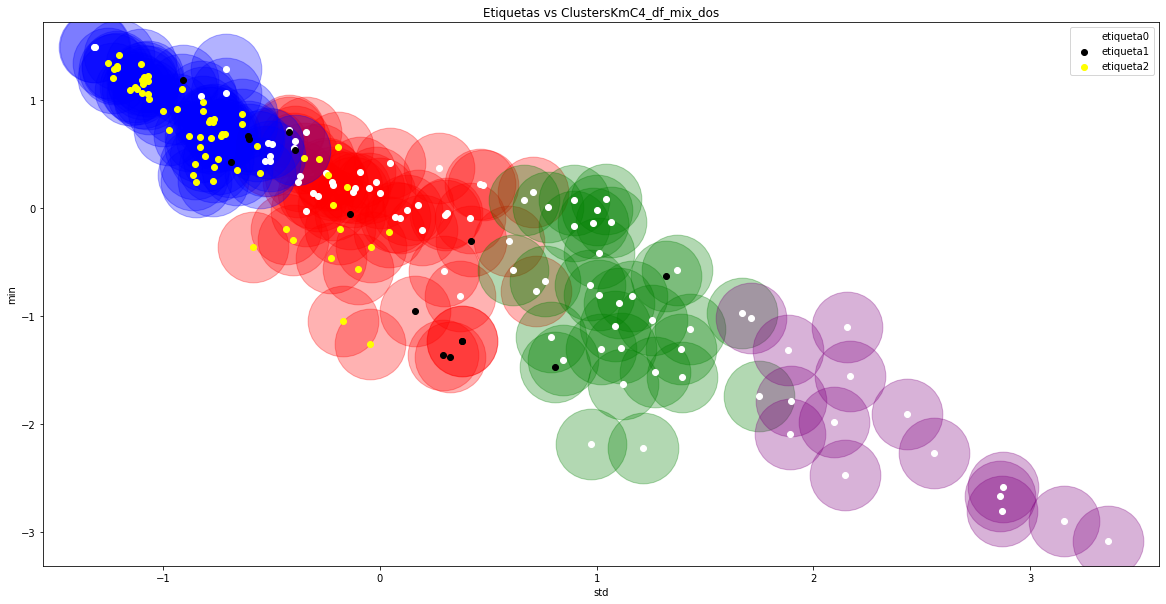

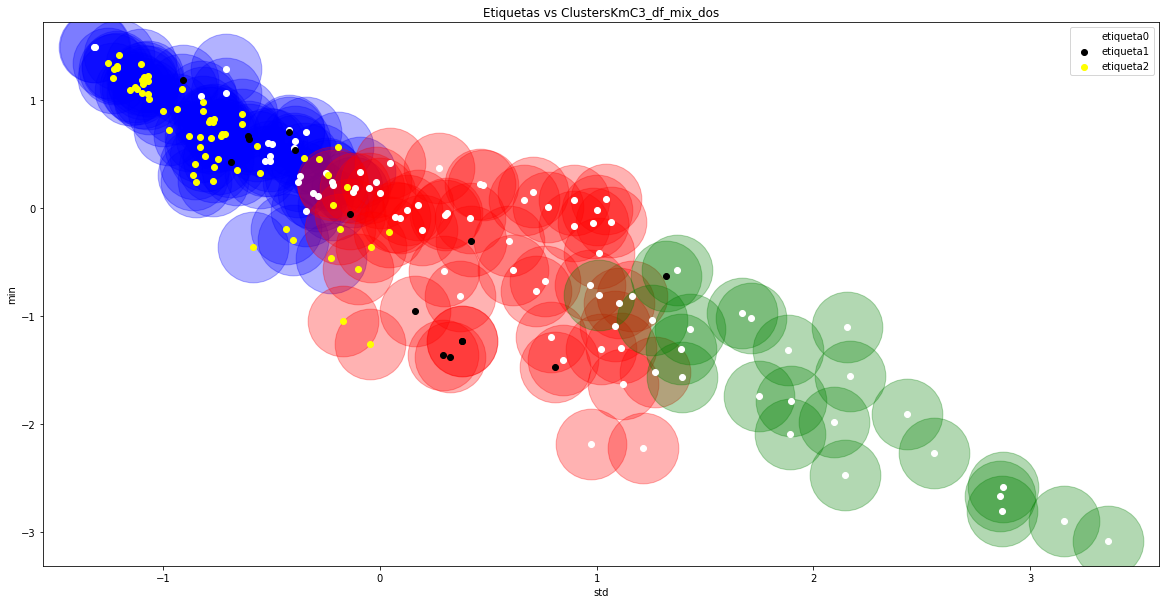

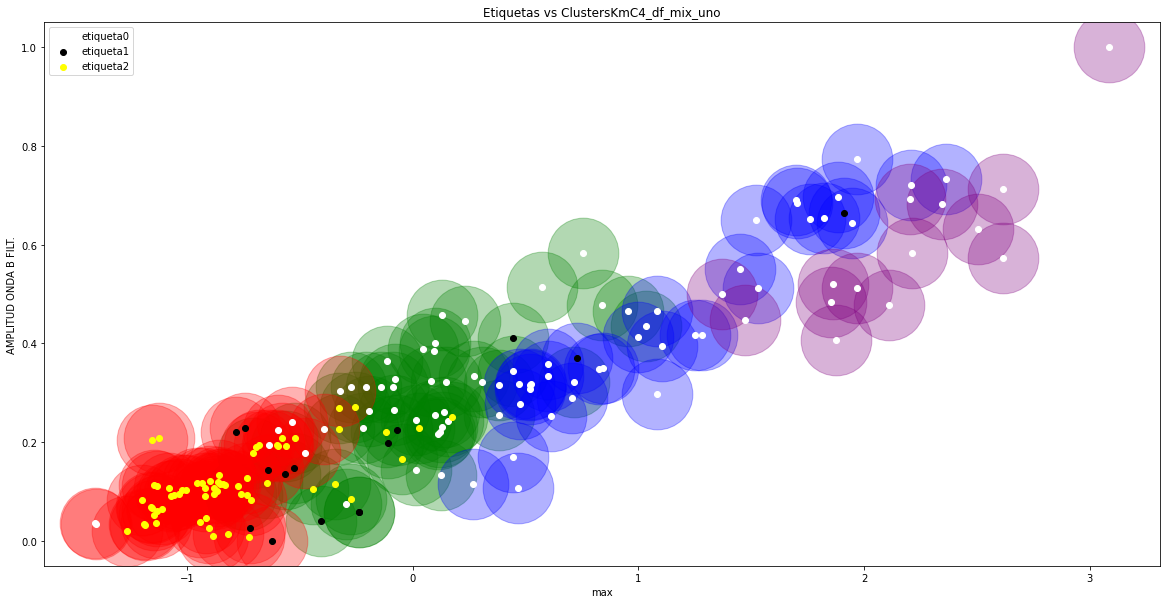

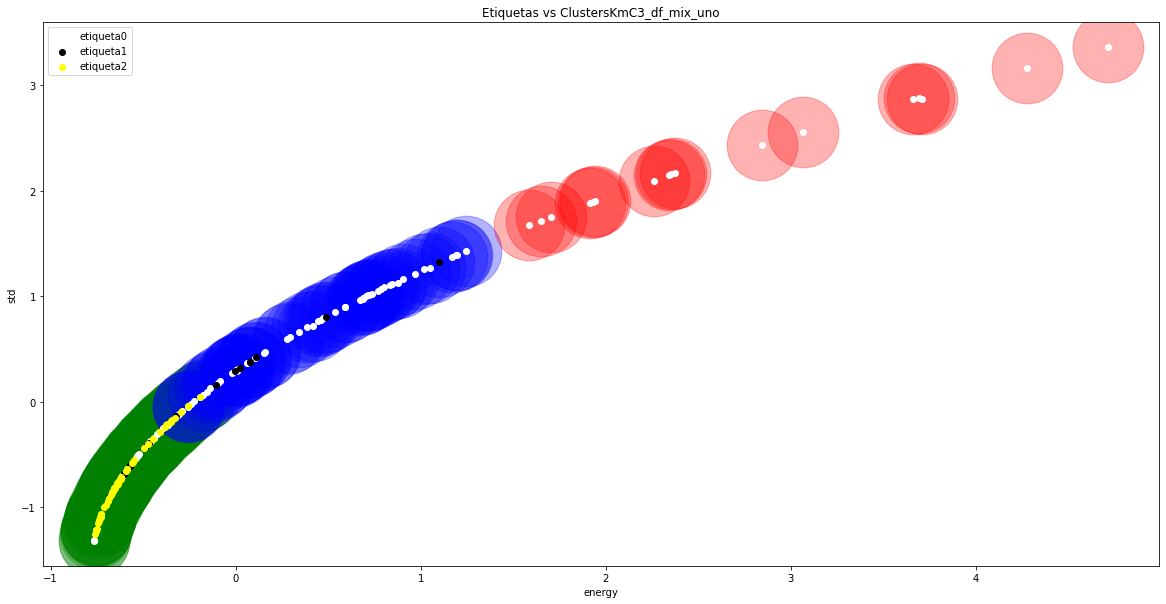

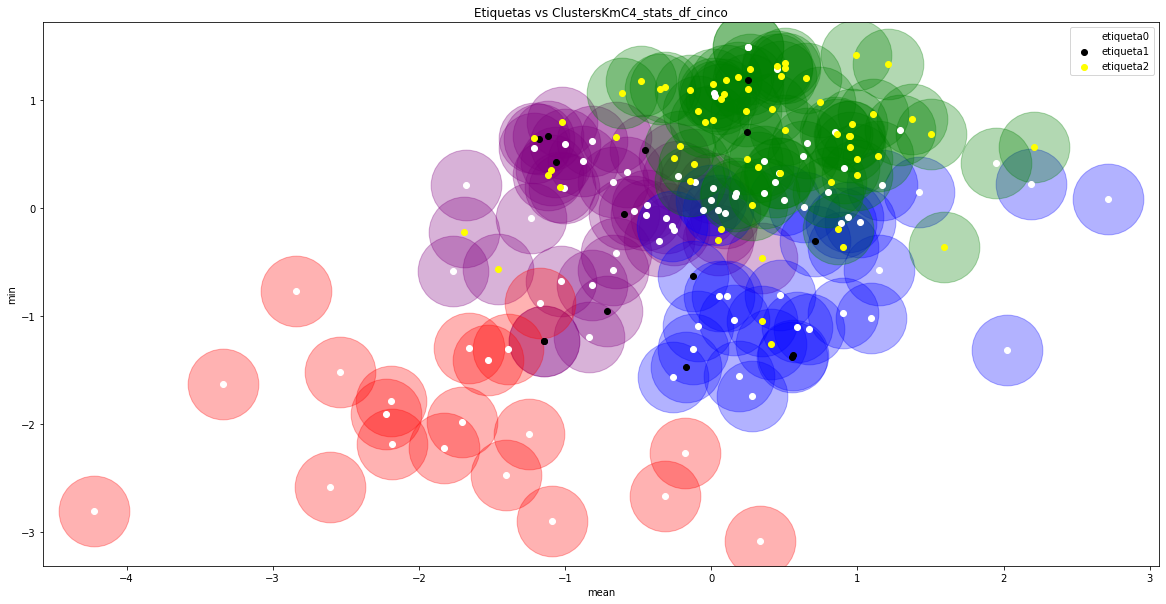

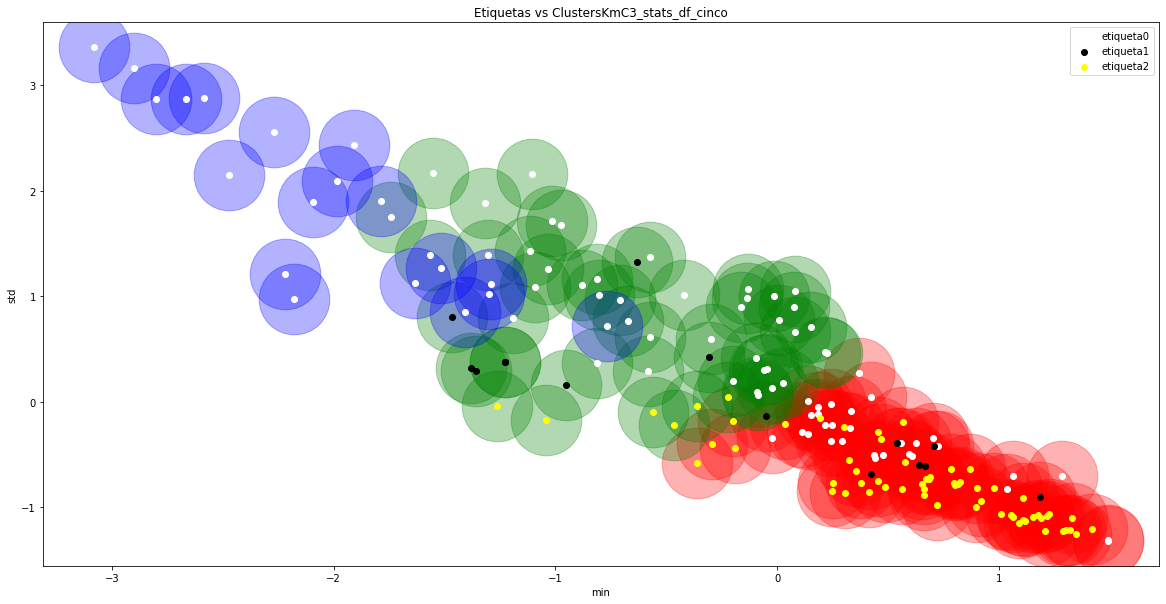

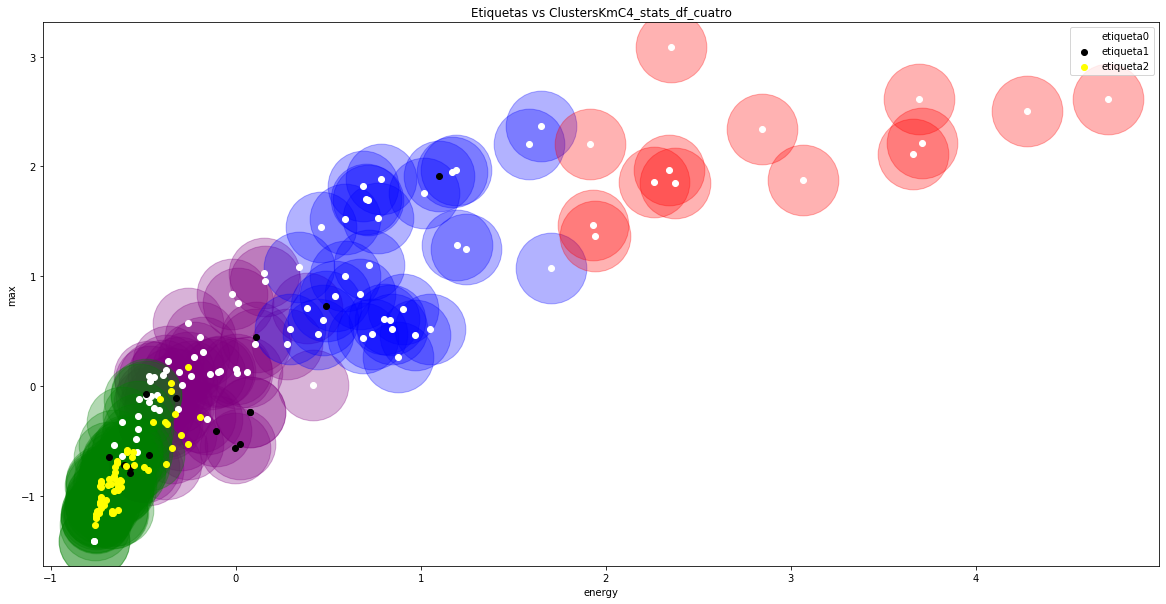

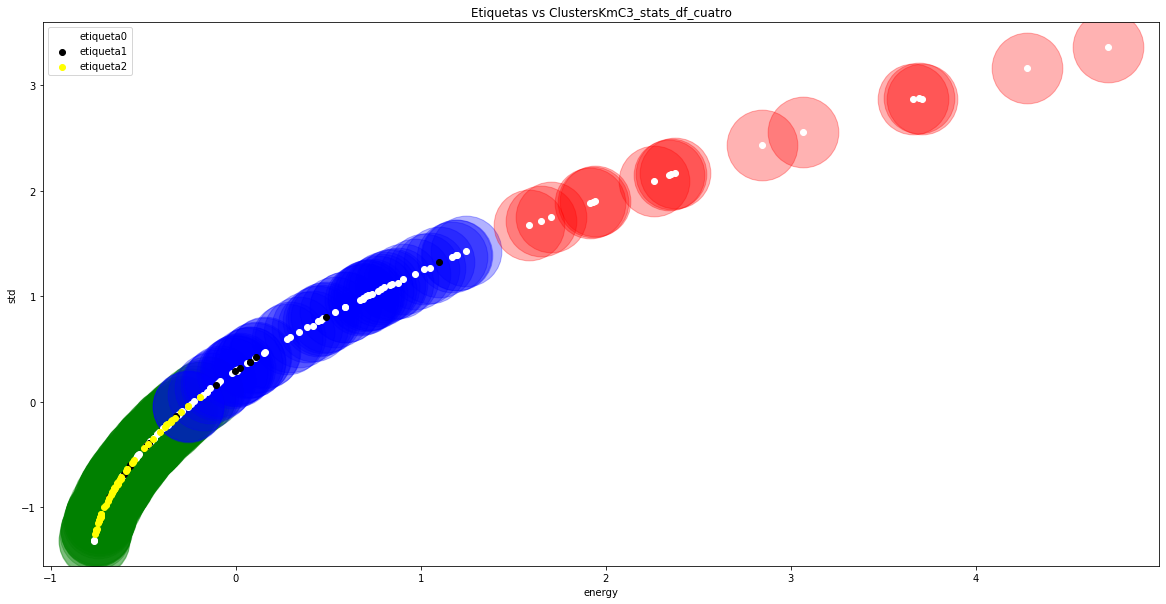

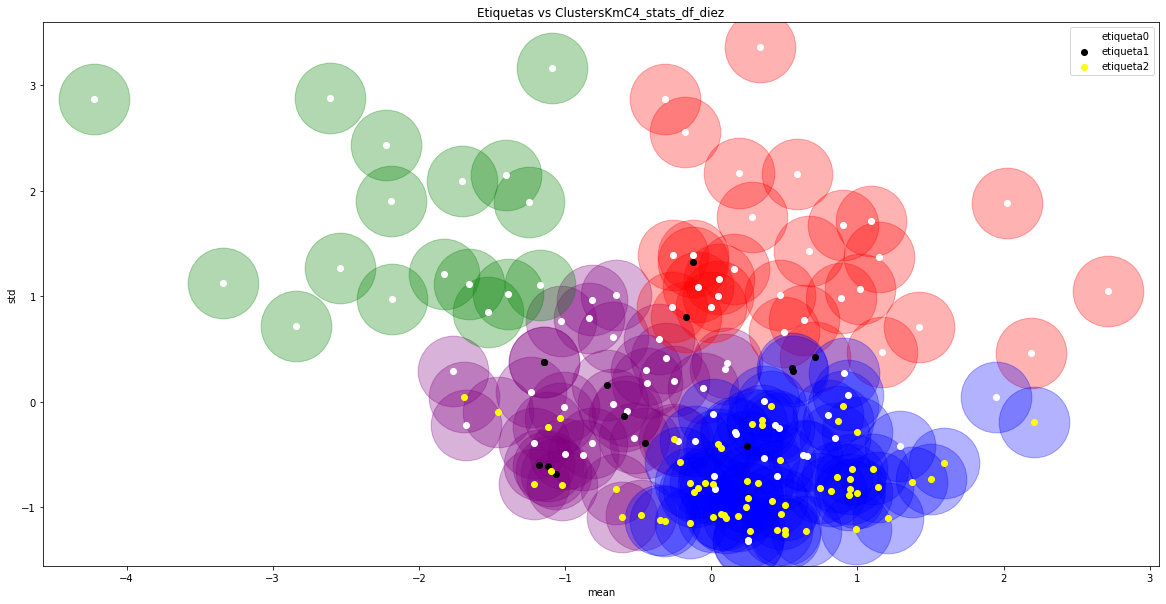

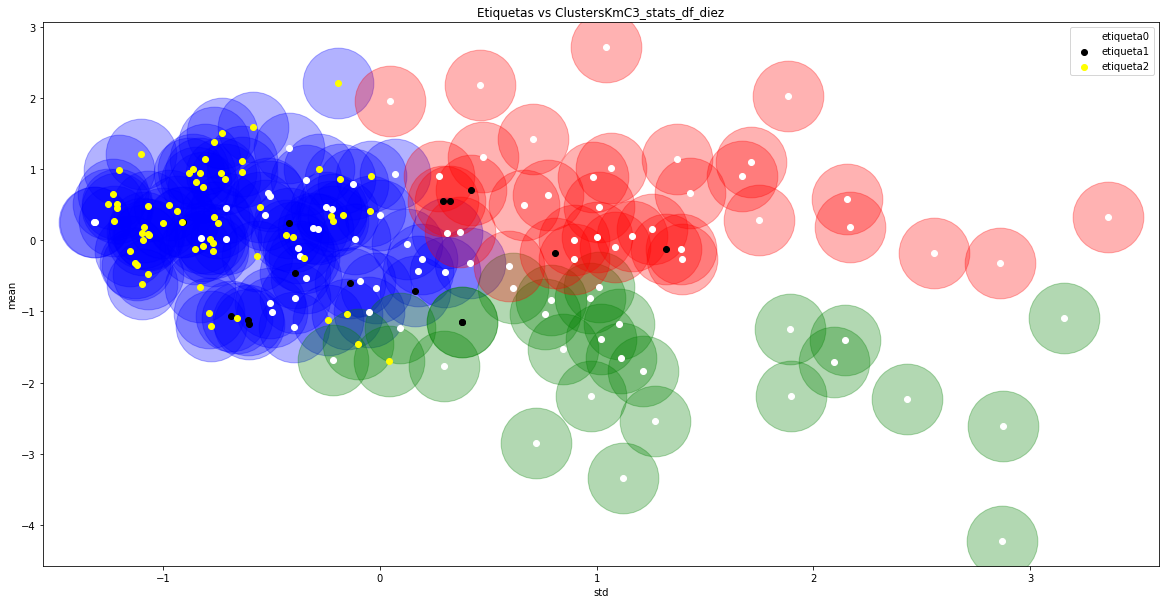

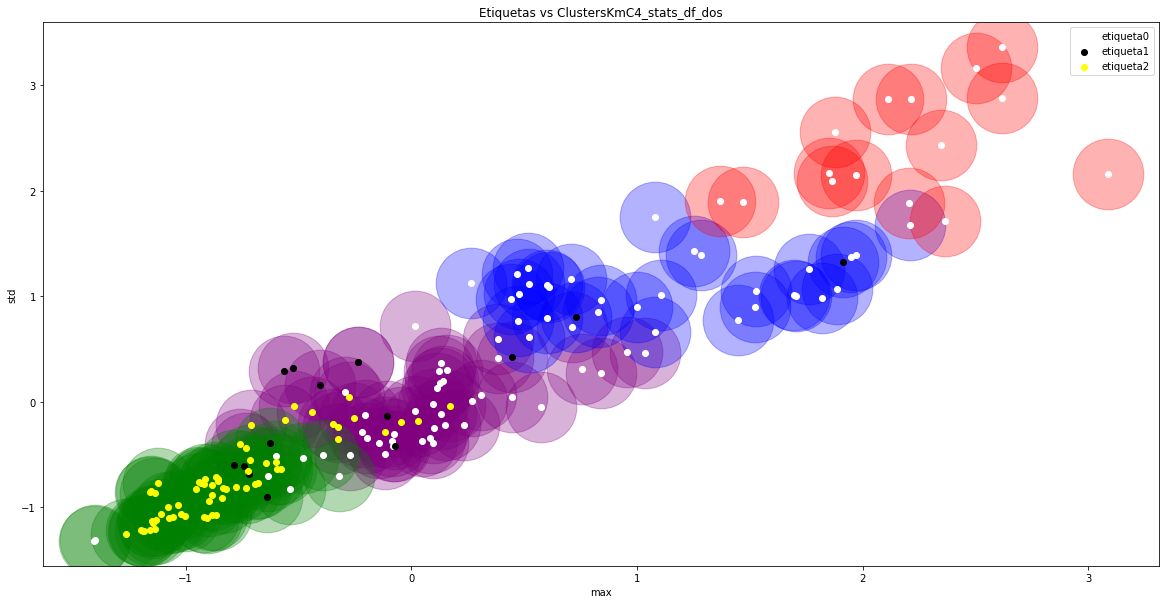

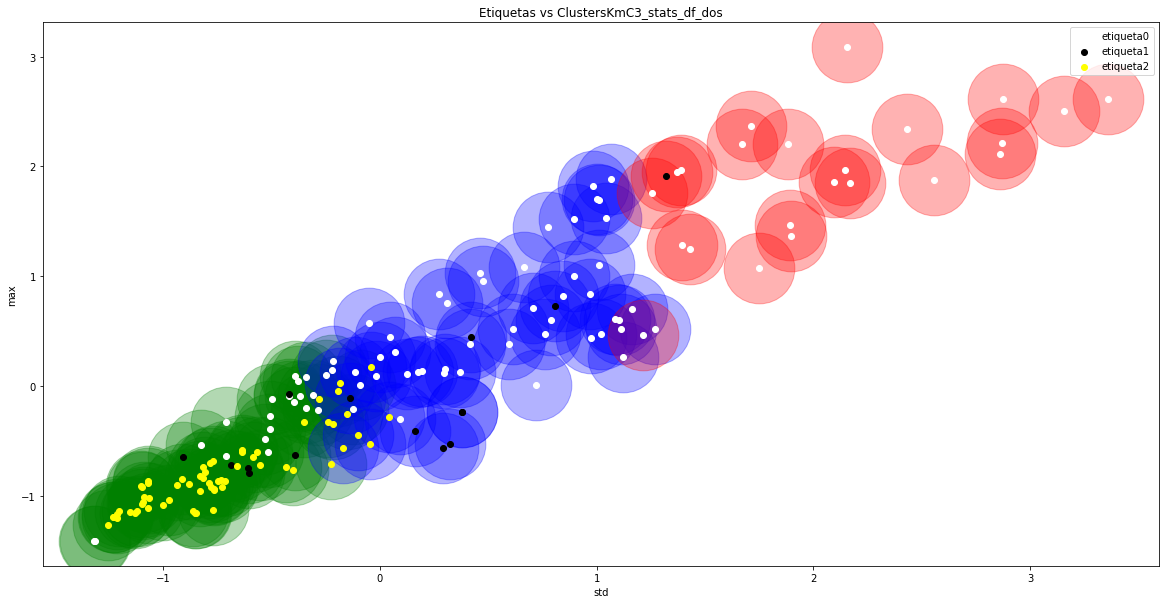

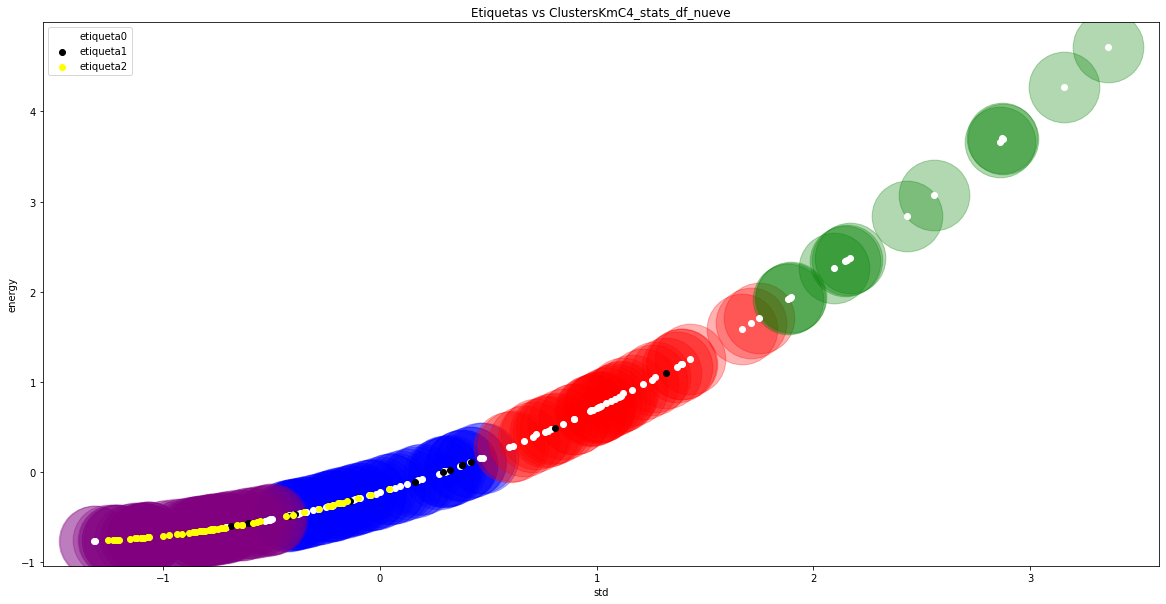

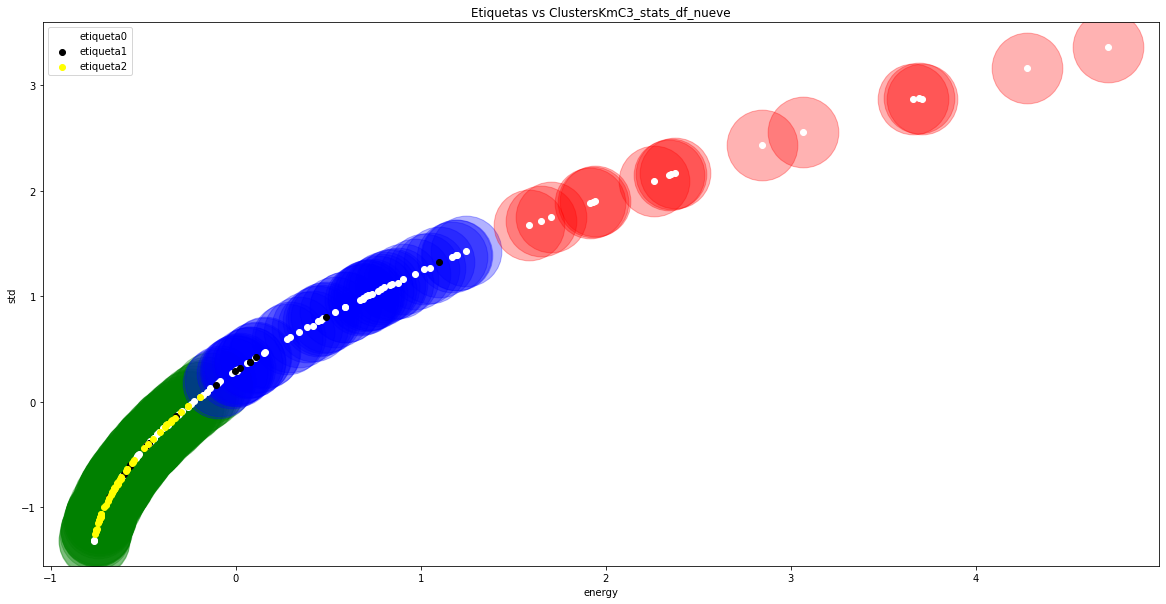

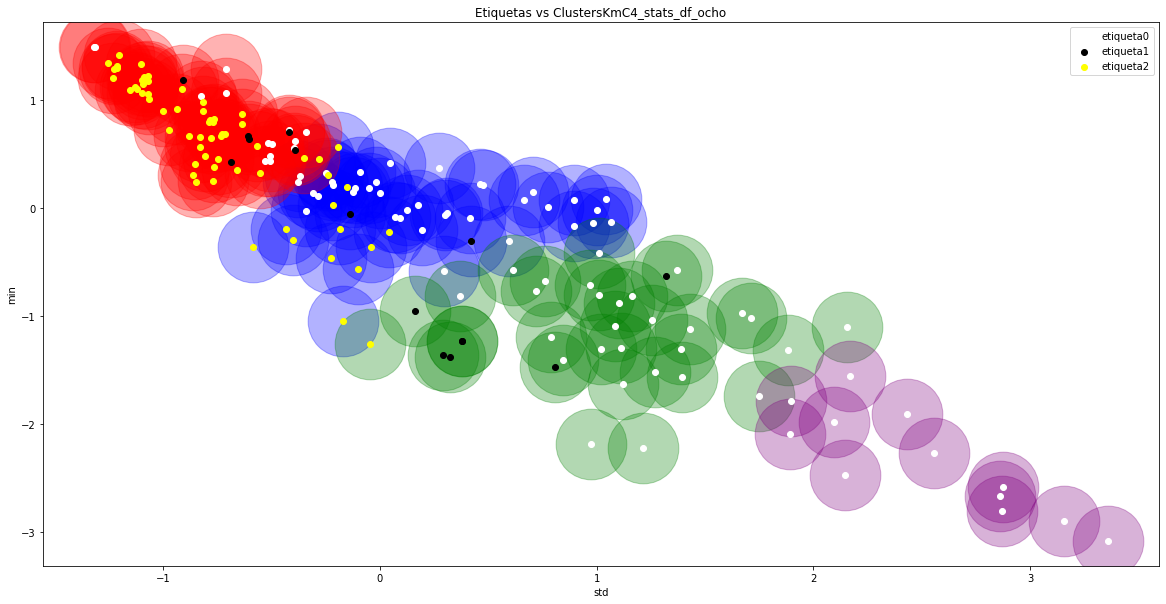

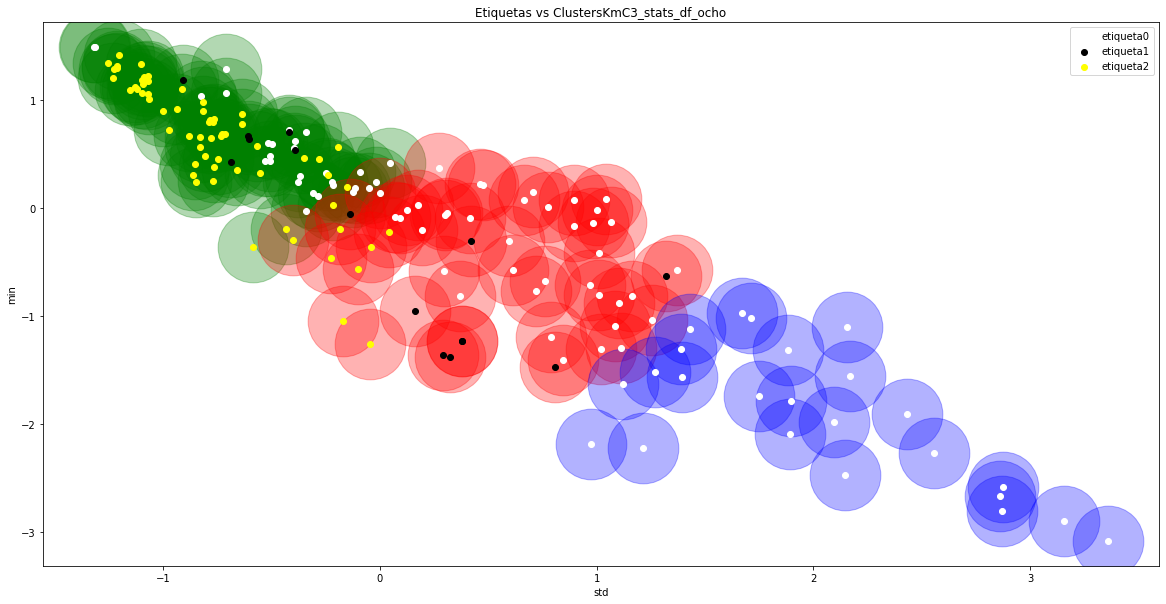

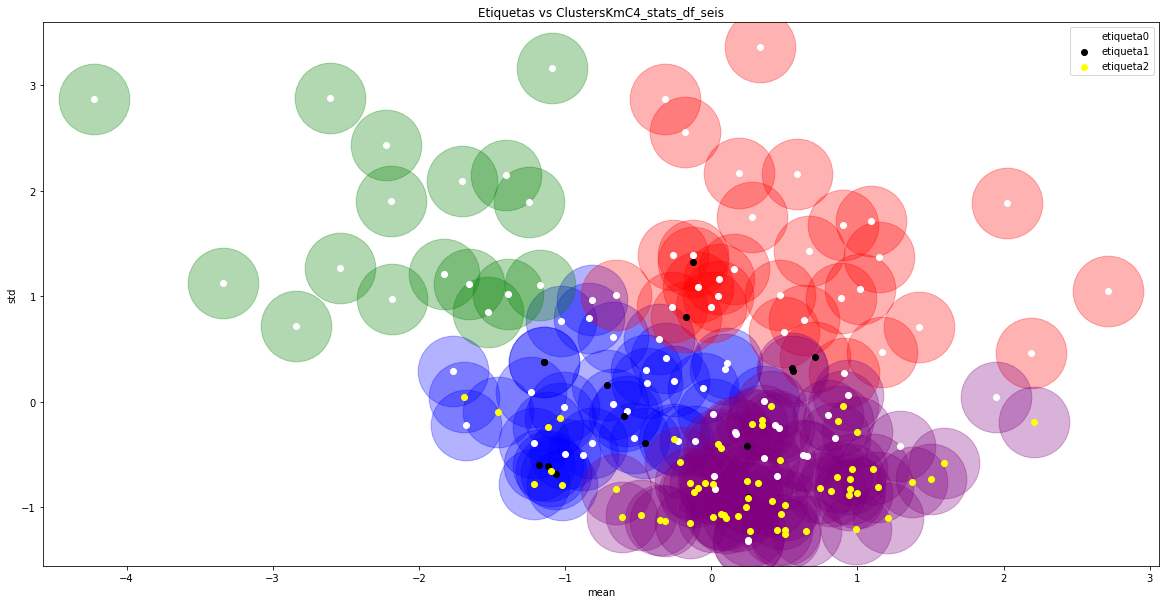

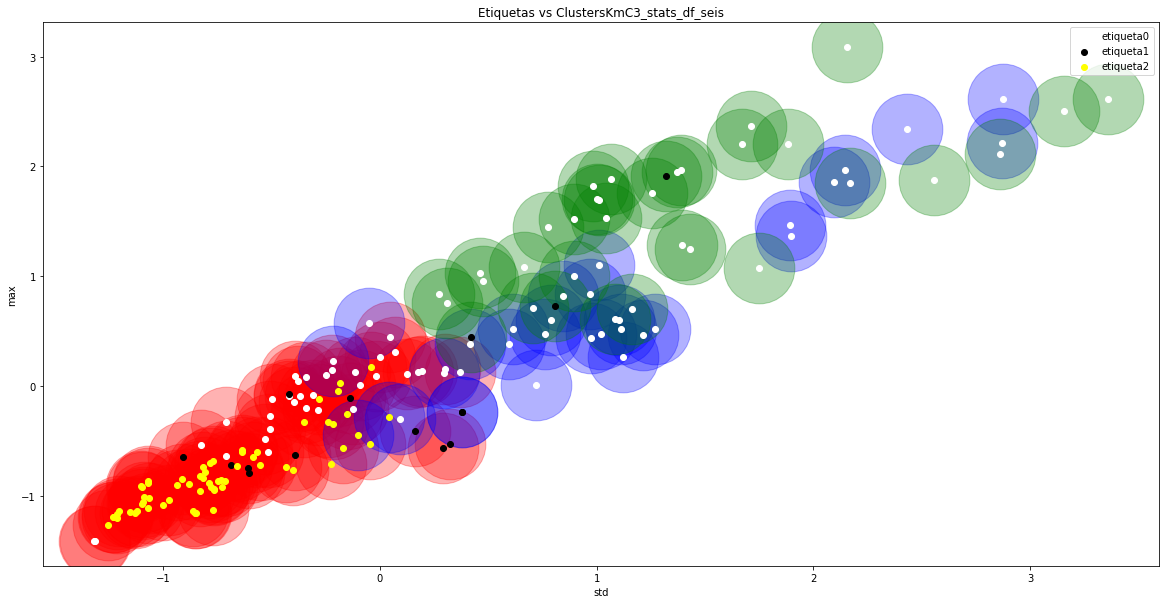

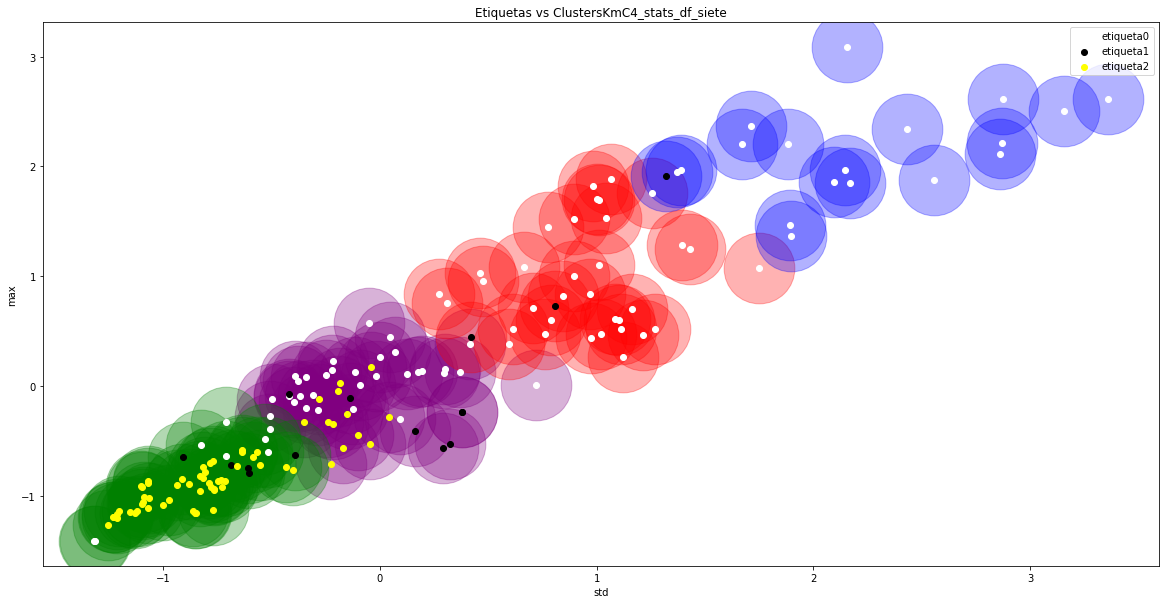

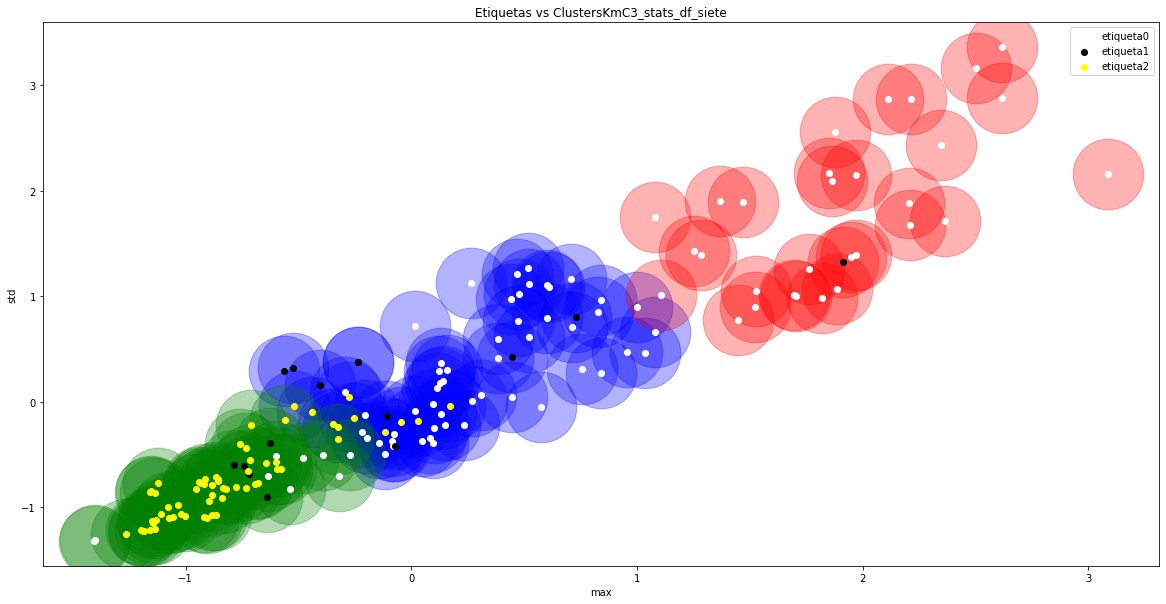

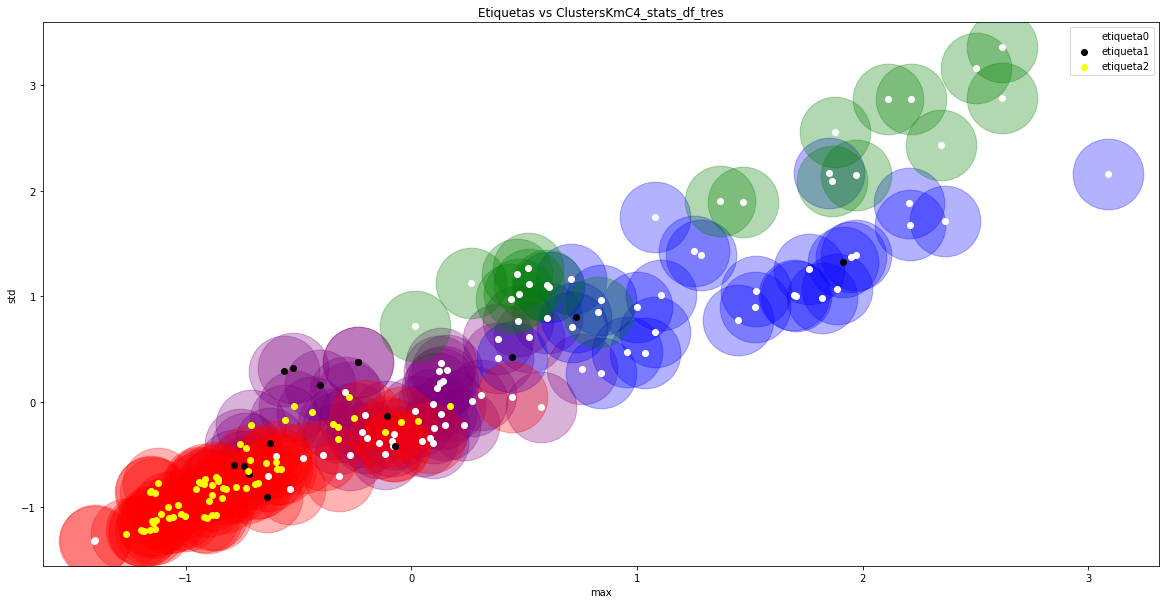

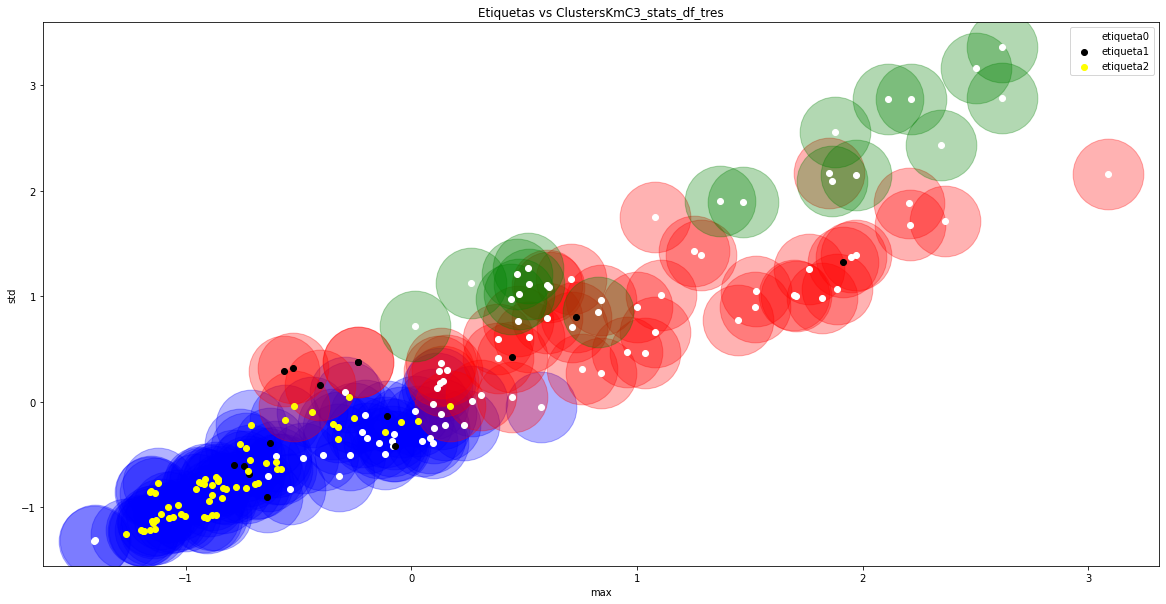

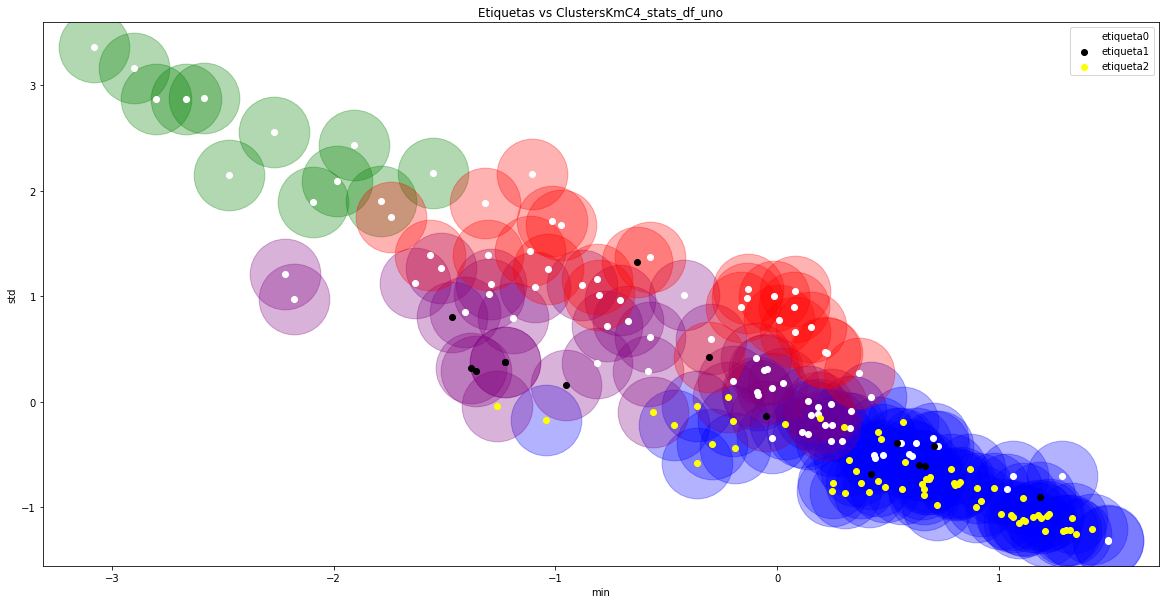

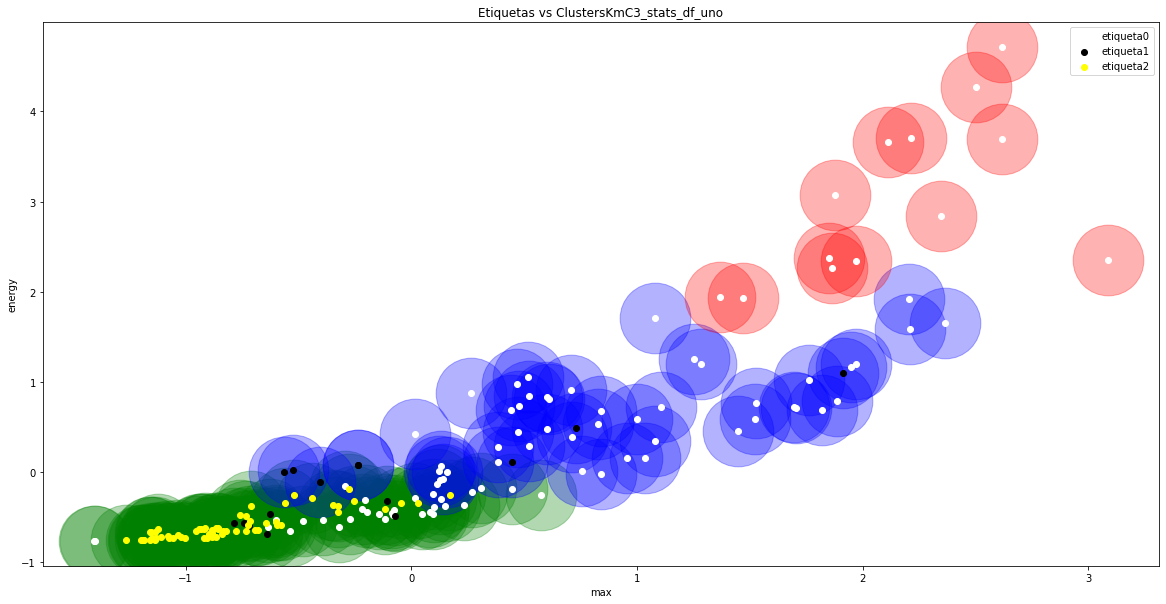

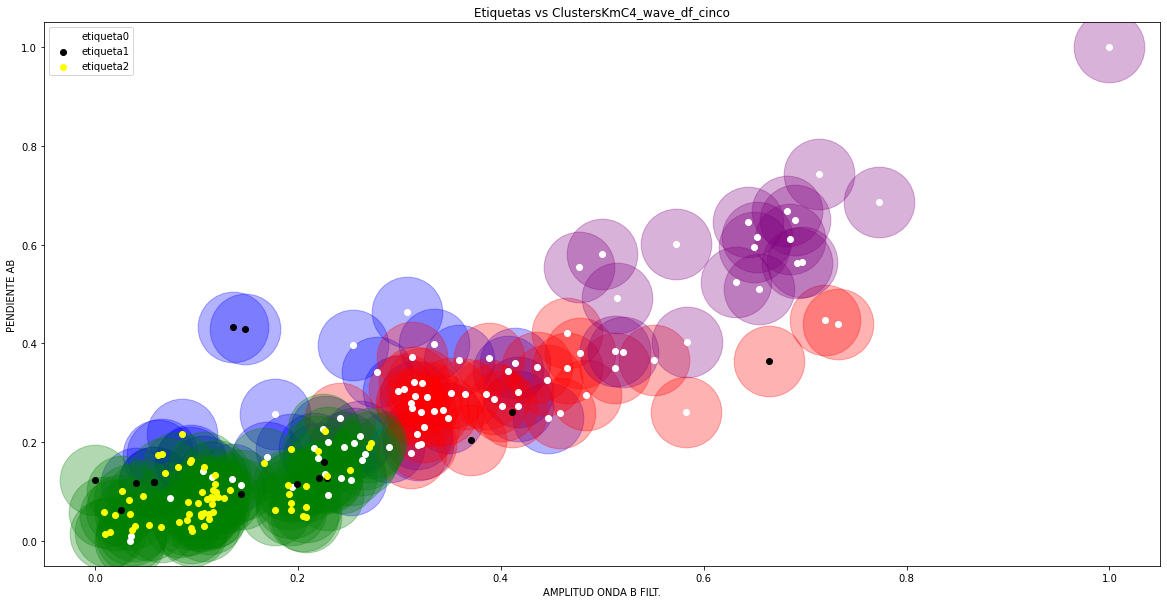

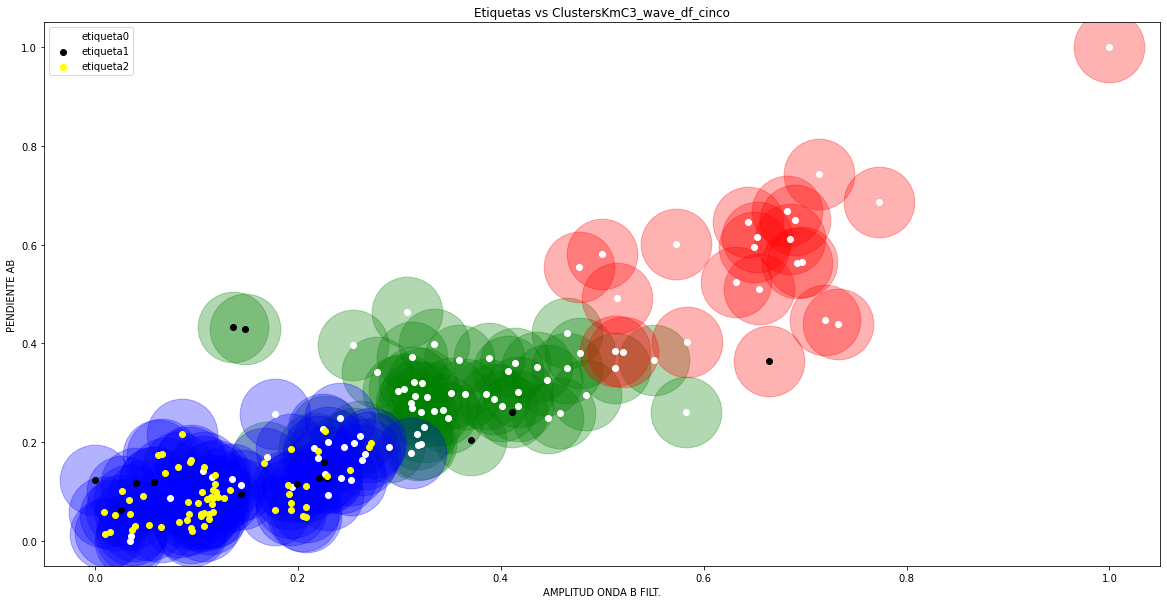

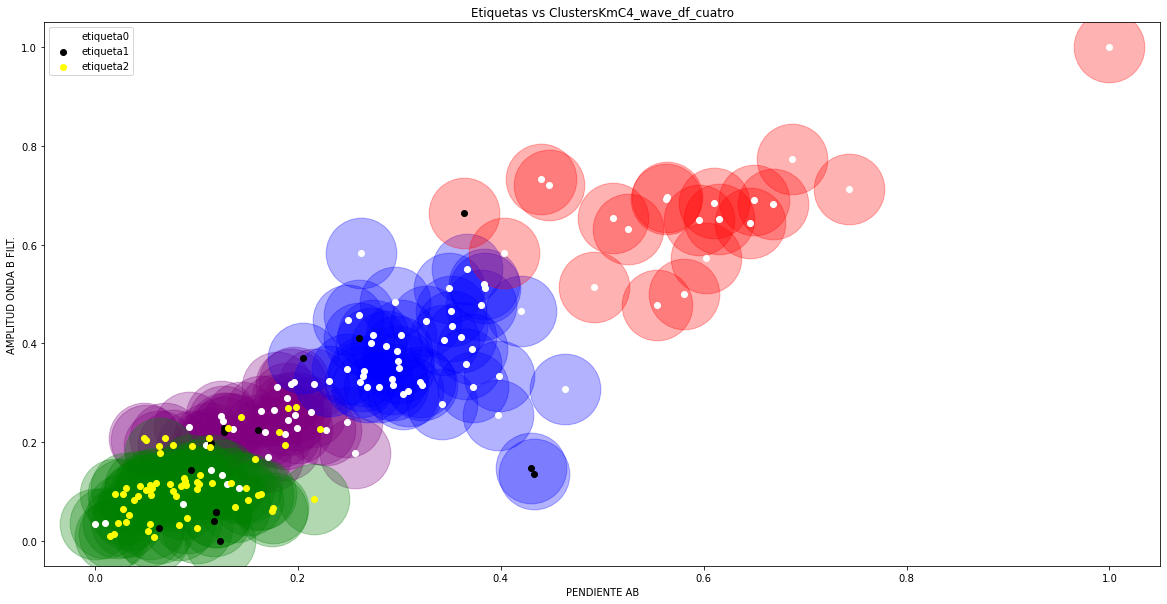

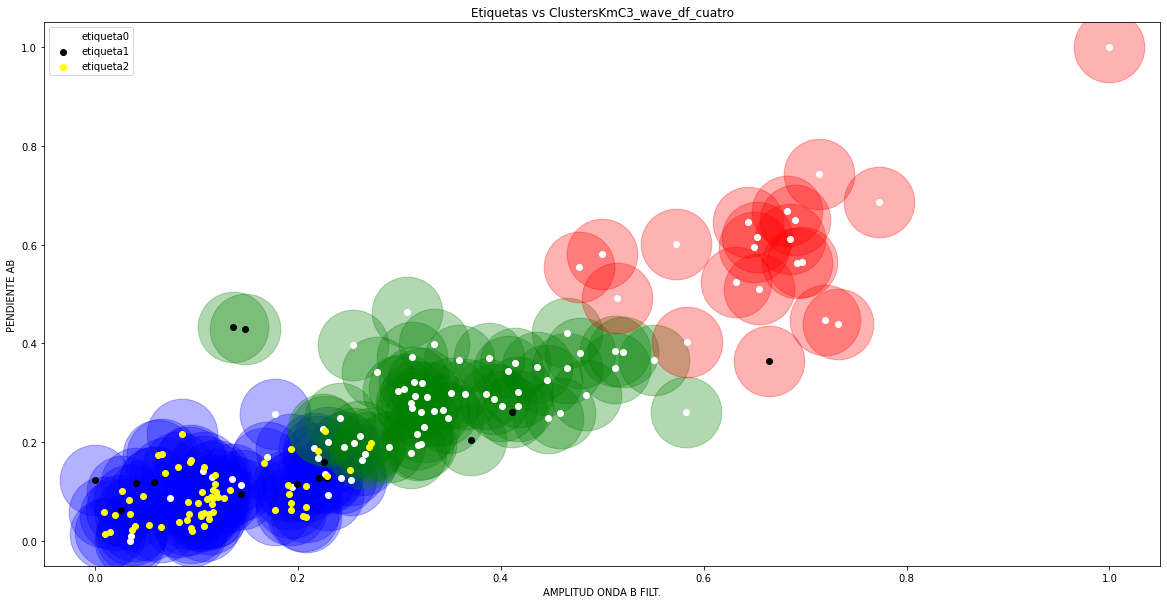

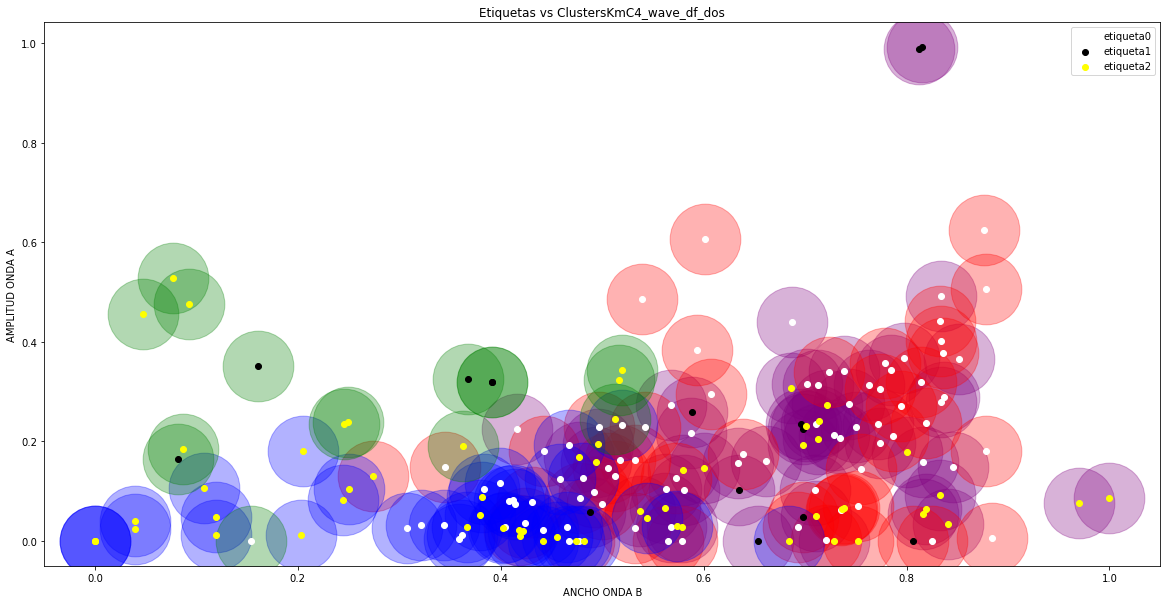

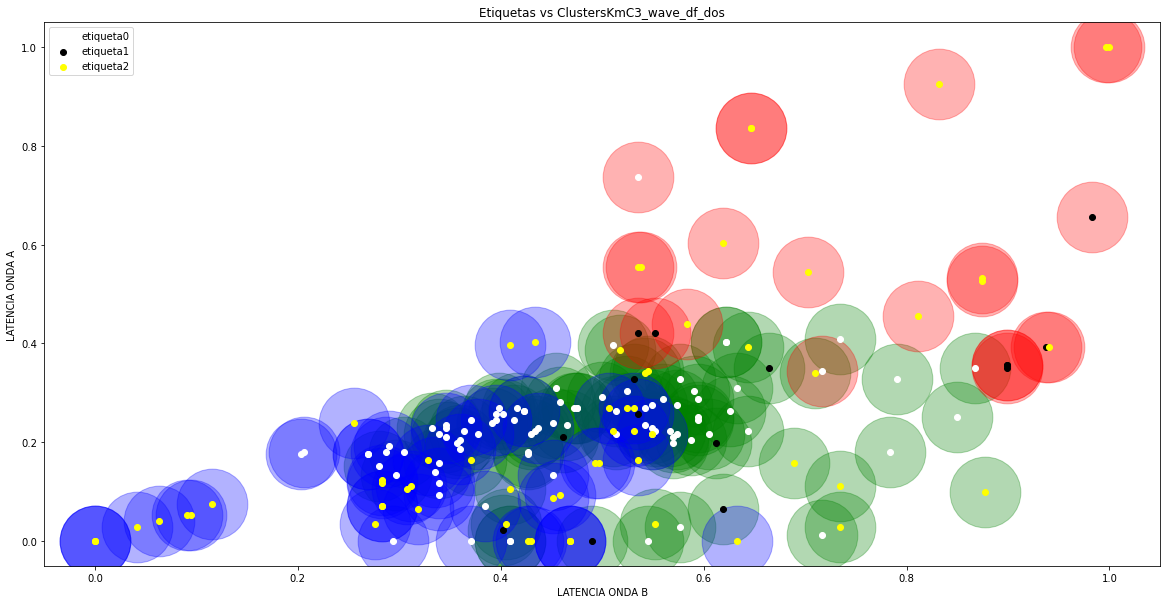

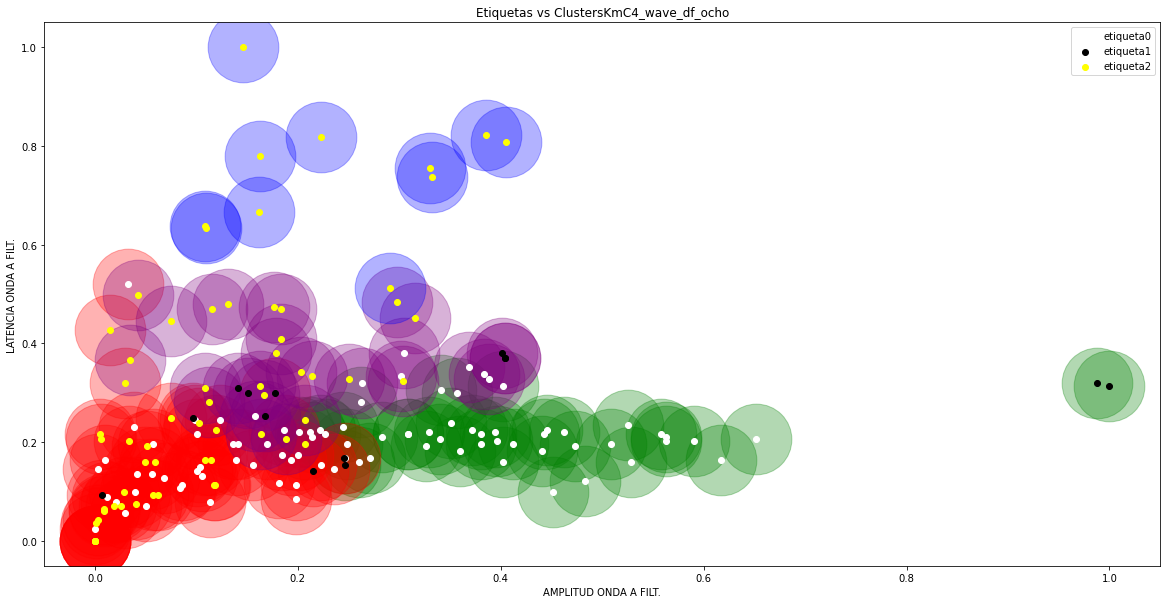

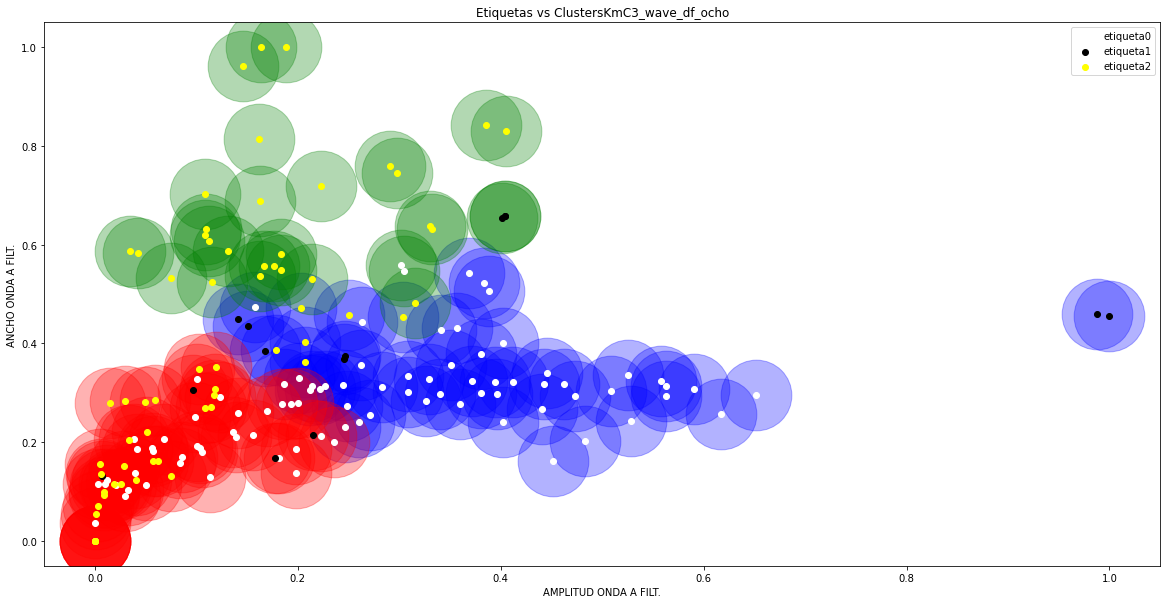

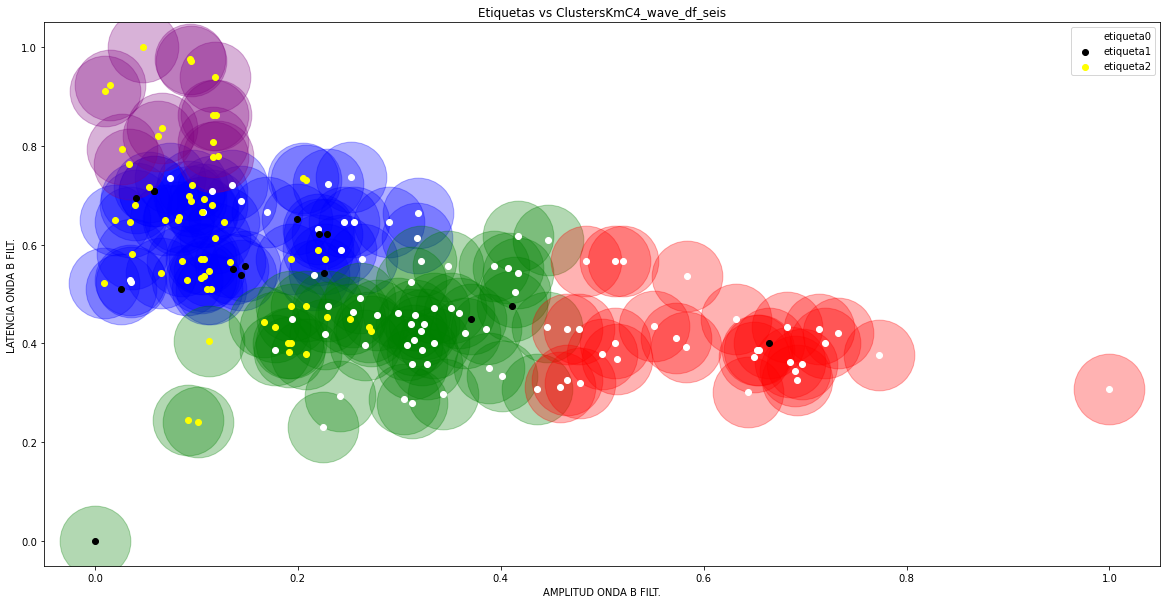

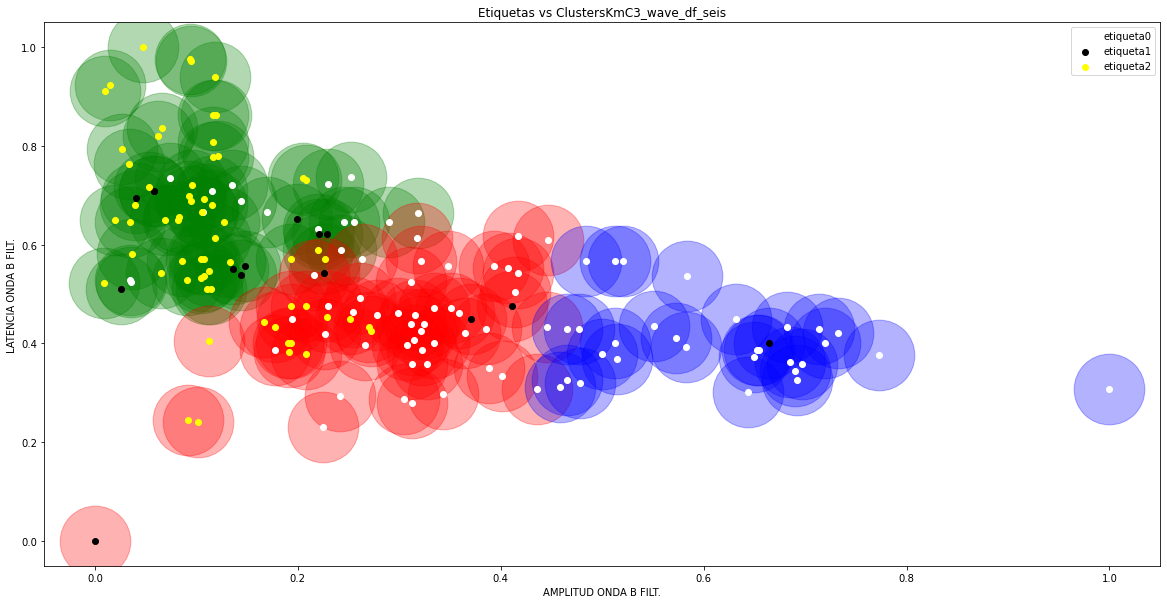

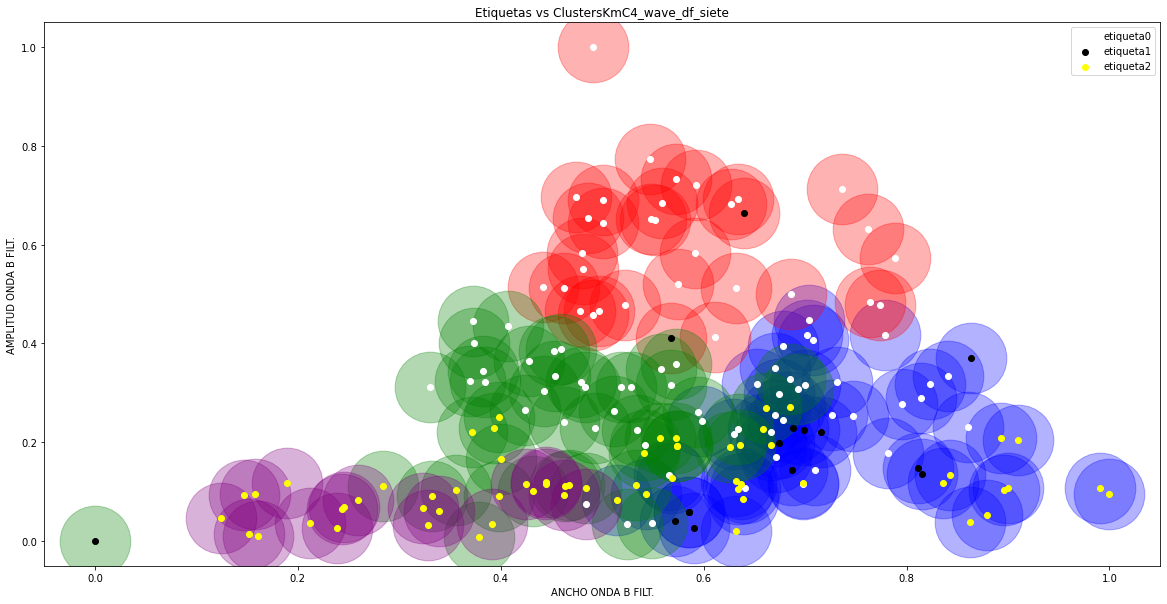

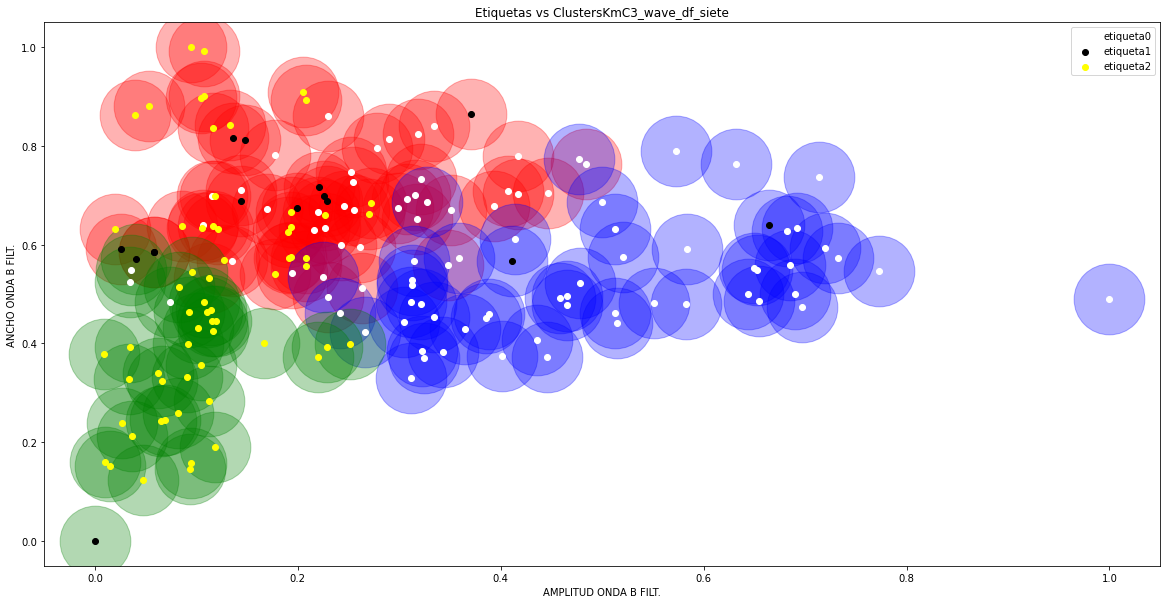

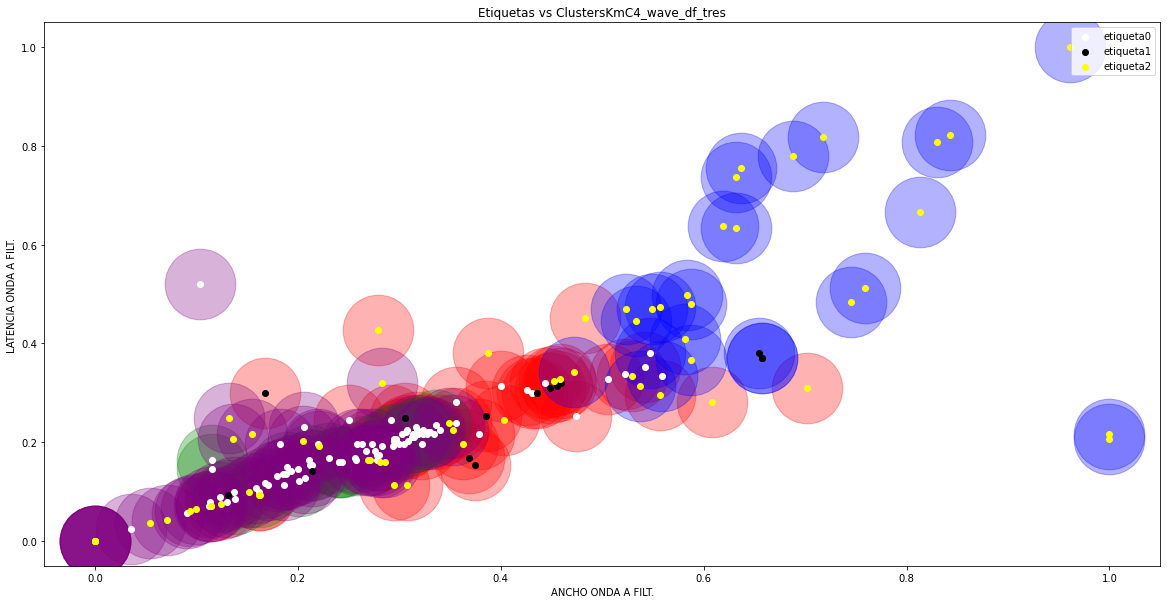

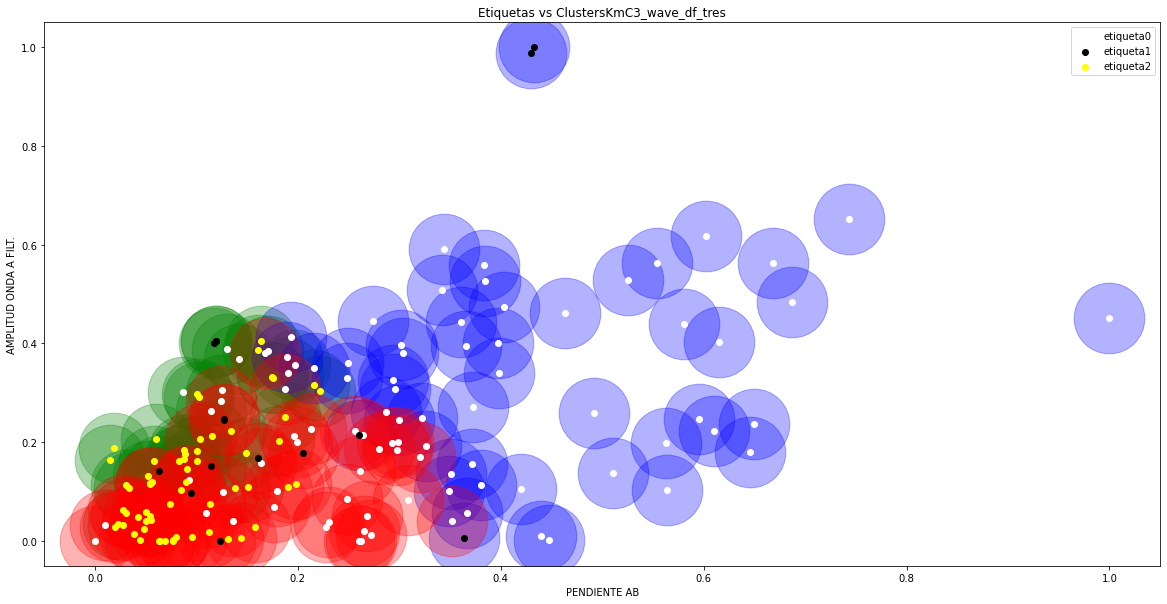

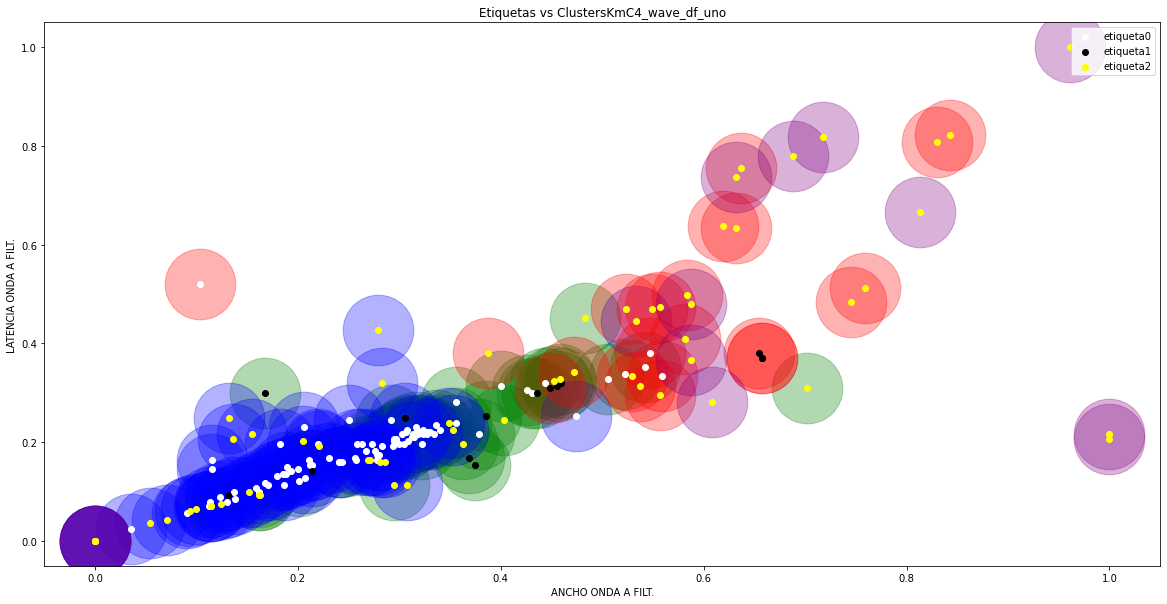

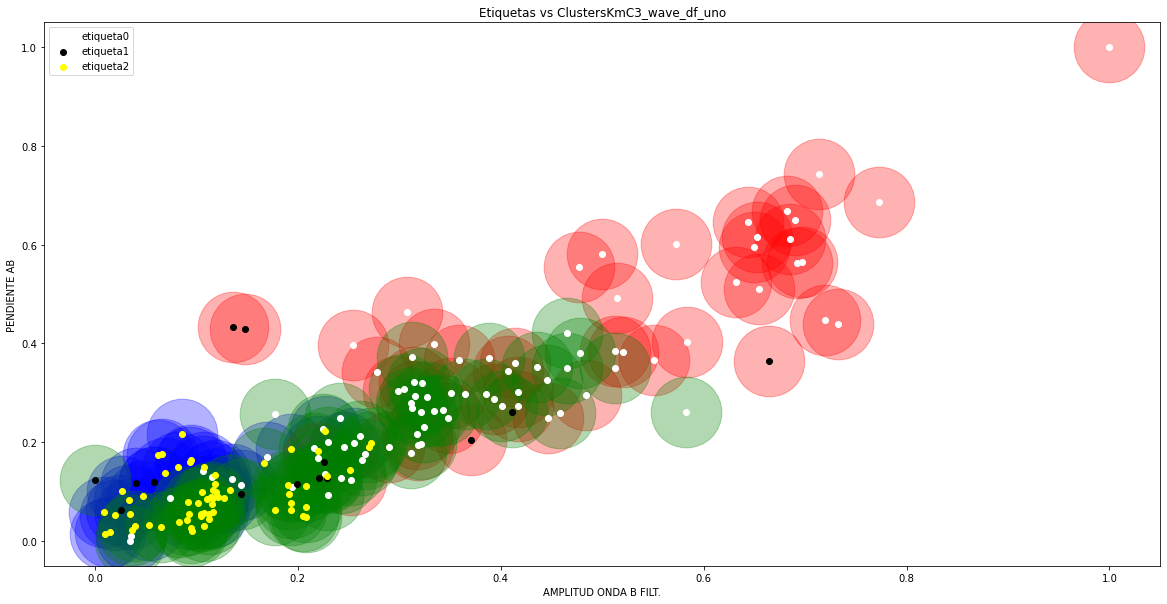

In [9]:
#dict de diccionario
model_unsupervised_dict = {"KmC4":km4,"KmC3":km3}
trained_models_unsup_dict = {}

score_unsup= pd.DataFrame()

for fila in range (len(list_df)):
    print("datarame N°:", list_df[fila][1])
    df_name=list_df[fila][1]
    df_name=df_name.split(".")[0]
    sub_dict = {} #sub dict va a llenarse de modelos entrenados 
    for model in model_unsupervised_dict.keys():
        print("model", model)
        each_df= pd.read_excel(main_path+"/"+list_df[fila][1],index_col=0)
        print(each_df)
        
        sub_dict[model] = unsupervised_training_models(each_df,score_unsup, model_unsupervised_dict[model], str(model),str(df_name))
        
        
    trained_models_unsup_dict[list_df[fila][1]] = sub_dict
    
    

In [10]:
score_unsup

KmC4      KmC3
df_mix_dos       0.621161  0.617991
df_mix_uno       0.622218  0.605100
stats_df_cinco   0.595590  0.578684
stats_df_cuatro  0.610101  0.605100
stats_df_diez    0.595520  0.575655
stats_df_dos     0.621161  0.612919
stats_df_nueve   0.624190  0.596506
stats_df_ocho    0.606157  0.579670
stats_df_seis    0.622852  0.571217
stats_df_siete   0.645041  0.663145
stats_df_tres    0.610031  0.592984
stats_df_uno     0.589955  0.600873
wave_df_cinco    0.643702  0.658495
wave_df_cuatro   0.650113  0.650042
wave_df_dos      0.580657  0.621372
wave_df_ocho     0.595661  0.603480
wave_df_seis     0.582981  0.600099
wave_df_siete    0.564877  0.633066
wave_df_tres     0.567484  0.618555
wave_df_uno      0.581361  0.594745

datarame N°: df_mix_dos.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.866667  0.962963  0.912281  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.894737  0.894737  0.894737  19.000000
accuracy       0.882353  0.882353  0.882353   0.882353
macro avg      0.920468  0.752567  0.792815  51.000000
weighted avg   0.890196  0.882353  0.872328  51.000000


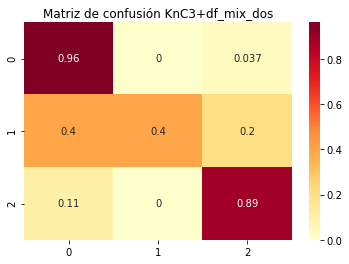

model scvL
              precision    recall  f1-score    support
0              0.923077  0.888889  0.905660  27.000000
1              0.285714  0.400000  0.333333   5.000000
2              0.888889  0.842105  0.864865  19.000000
accuracy       0.823529  0.823529  0.823529   0.823529
macro avg      0.699227  0.710331  0.701286  51.000000
weighted avg   0.847854  0.823529  0.834352  51.000000


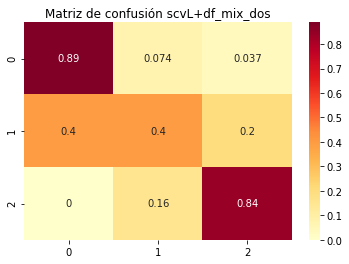

model RF
              precision    recall  f1-score    support
0              0.900000  1.000000  0.947368  27.000000
1              1.000000  0.600000  0.750000   5.000000
2              1.000000  0.947368  0.972973  19.000000
accuracy       0.941176  0.941176  0.941176   0.941176
macro avg      0.966667  0.849123  0.890114  51.000000
weighted avg   0.947059  0.941176  0.937558  51.000000


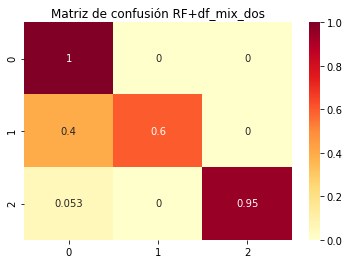

datarame N°: df_mix_uno.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.866667  0.962963  0.912281  27.000000
1              0.666667  0.400000  0.500000   5.000000
2              0.888889  0.842105  0.864865  19.000000
accuracy       0.862745  0.862745  0.862745   0.862745
macro avg      0.807407  0.735023  0.759049  51.000000
weighted avg   0.855338  0.862745  0.854196  51.000000


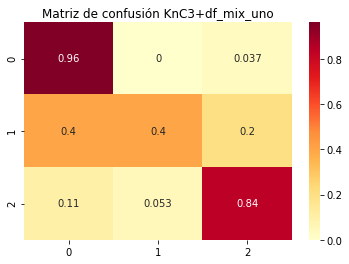

model scvL
              precision    recall  f1-score    support
0              0.923077  0.888889  0.905660  27.000000
1              0.333333  0.400000  0.363636   5.000000
2              0.842105  0.842105  0.842105  19.000000
accuracy       0.823529  0.823529  0.823529   0.823529
macro avg      0.699505  0.710331  0.703801  51.000000
weighted avg   0.835093  0.823529  0.828843  51.000000


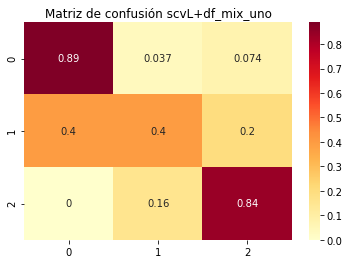

model RF
              precision    recall  f1-score    support
0              0.870968  1.000000  0.931034  27.000000
1              1.000000  0.600000  0.750000   5.000000
2              1.000000  0.894737  0.944444  19.000000
accuracy       0.921569  0.921569  0.921569   0.921569
macro avg      0.956989  0.831579  0.875160  51.000000
weighted avg   0.931689  0.921569  0.918282  51.000000


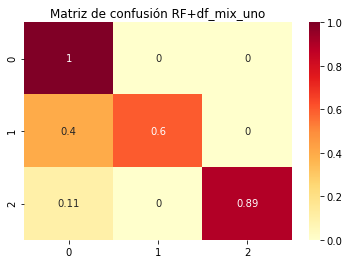

datarame N°: stats_df_cinco.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.735294  0.925926  0.819672  27.000000
1              1.000000  0.200000  0.333333   5.000000
2              0.812500  0.684211  0.742857  19.000000
accuracy       0.764706  0.764706  0.764706   0.764706
macro avg      0.849265  0.603379  0.631954  51.000000
weighted avg   0.790009  0.764706  0.743375  51.000000


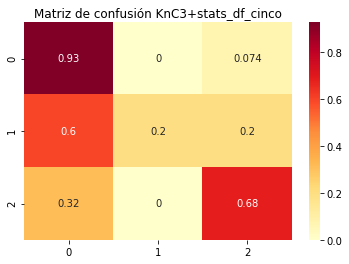

model scvL
              precision    recall  f1-score    support
0              0.913043  0.777778  0.840000  27.000000
1              0.272727  0.600000  0.375000   5.000000
2              0.941176  0.842105  0.888889  19.000000
accuracy       0.784314  0.784314  0.784314   0.784314
macro avg      0.708982  0.739961  0.701296  51.000000
weighted avg   0.860748  0.784314  0.812625  51.000000


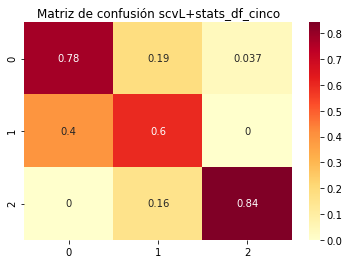

model RF
              precision    recall  f1-score    support
0              0.818182  1.000000  0.900000  27.000000
1              0.750000  0.600000  0.666667   5.000000
2              1.000000  0.736842  0.848485  19.000000
accuracy       0.862745  0.862745  0.862745   0.862745
macro avg      0.856061  0.778947  0.805051  51.000000
weighted avg   0.879234  0.862745  0.857932  51.000000


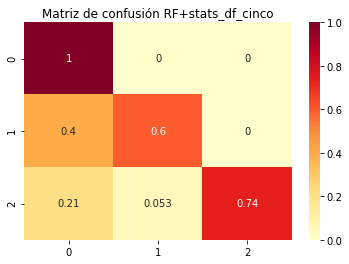

datarame N°: stats_df_cuatro.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.838710  0.962963  0.896552  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.888889  0.842105  0.864865  19.000000
accuracy       0.862745  0.862745  0.862745   0.862745
macro avg      0.909200  0.735023  0.777615  51.000000
weighted avg   0.873217  0.862745  0.852872  51.000000


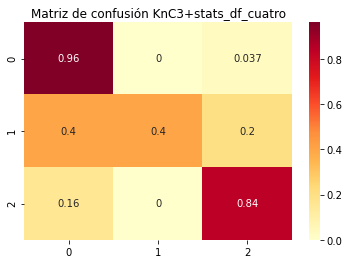

model scvL
              precision    recall  f1-score    support
0              0.920000  0.851852  0.884615  27.000000
1              0.375000  0.600000  0.461538   5.000000
2              0.888889  0.842105  0.864865  19.000000
accuracy       0.823529  0.823529  0.823529   0.823529
macro avg      0.727963  0.764652  0.737006  51.000000
weighted avg   0.854978  0.823529  0.835779  51.000000


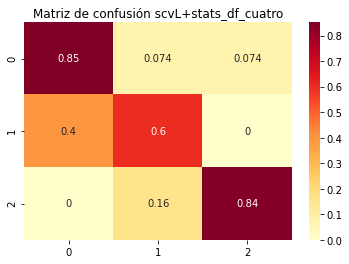

model RF
              precision    recall  f1-score    support
0              0.870968  1.000000  0.931034  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.944444  0.894737  0.918919  19.000000
accuracy       0.901961  0.901961  0.901961   0.901961
macro avg      0.938471  0.764912  0.807127  51.000000
weighted avg   0.910992  0.901961  0.891265  51.000000


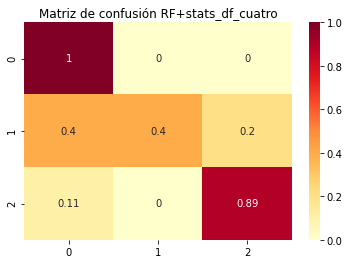

datarame N°: stats_df_diez.xlsx
model KnC3
              precision    recall  f1-score   support
0              0.696970  0.851852  0.766667  27.00000
1              0.500000  0.200000  0.285714   5.00000
2              0.812500  0.684211  0.742857  19.00000
accuracy       0.725490  0.725490  0.725490   0.72549
macro avg      0.669823  0.578687  0.598413  51.00000
weighted avg   0.720700  0.725490  0.710644  51.00000


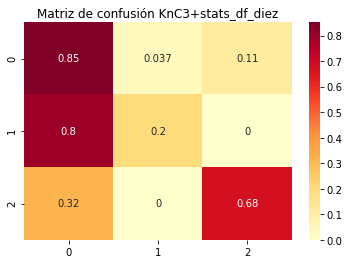

model scvL
              precision    recall  f1-score    support
0              0.875000  0.777778  0.823529  27.000000
1              0.200000  0.400000  0.266667   5.000000
2              0.882353  0.789474  0.833333  19.000000
accuracy       0.745098  0.745098  0.745098   0.745098
macro avg      0.652451  0.655750  0.641176  51.000000
weighted avg   0.811563  0.745098  0.772587  51.000000


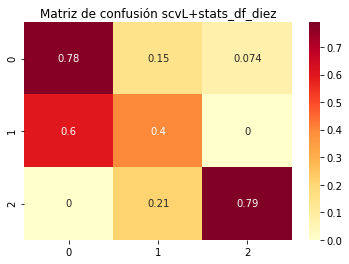

model RF
              precision    recall  f1-score    support
0              0.787879  0.962963  0.866667  27.000000
1              0.500000  0.400000  0.444444   5.000000
2              1.000000  0.736842  0.848485  19.000000
accuracy       0.823529  0.823529  0.823529   0.823529
macro avg      0.762626  0.699935  0.719865  51.000000
weighted avg   0.838681  0.823529  0.818499  51.000000


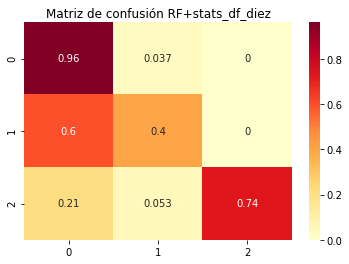

datarame N°: stats_df_dos.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.838710  0.962963  0.896552  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.888889  0.842105  0.864865  19.000000
accuracy       0.862745  0.862745  0.862745   0.862745
macro avg      0.909200  0.735023  0.777615  51.000000
weighted avg   0.873217  0.862745  0.852872  51.000000


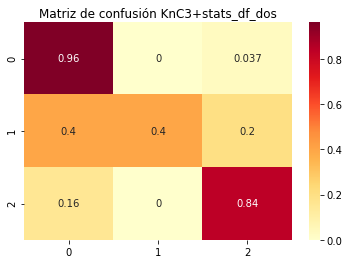

model scvL
              precision    recall  f1-score    support
0              0.920000  0.851852  0.884615  27.000000
1              0.333333  0.600000  0.428571   5.000000
2              0.941176  0.842105  0.888889  19.000000
accuracy       0.823529  0.823529  0.823529   0.823529
macro avg      0.731503  0.764652  0.734025  51.000000
weighted avg   0.870373  0.823529  0.841497  51.000000


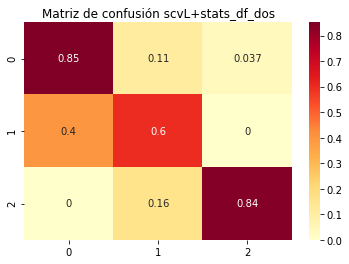

model RF
              precision    recall  f1-score    support
0              0.870968  1.000000  0.931034  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.944444  0.894737  0.918919  19.000000
accuracy       0.901961  0.901961  0.901961   0.901961
macro avg      0.938471  0.764912  0.807127  51.000000
weighted avg   0.910992  0.901961  0.891265  51.000000


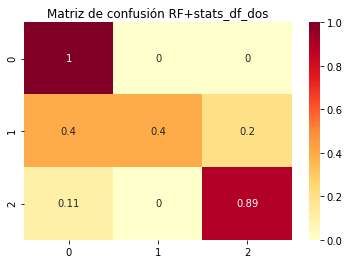

datarame N°: stats_df_nueve.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.757576  0.925926  0.833333  27.000000
1              0.000000  0.000000  0.000000   5.000000
2              0.833333  0.789474  0.810811  19.000000
accuracy       0.784314  0.784314  0.784314   0.784314
macro avg      0.530303  0.571800  0.548048  51.000000
weighted avg   0.711527  0.784314  0.743243  51.000000


C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\toto_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


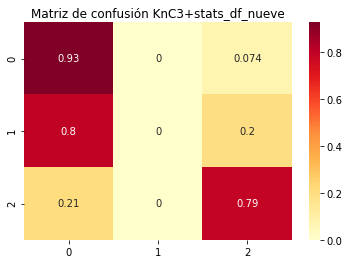

model scvL
              precision    recall  f1-score   support
0              0.950000  0.703704  0.808511  27.00000
1              0.214286  0.600000  0.315789   5.00000
2              0.882353  0.789474  0.833333  19.00000
accuracy       0.725490  0.725490  0.725490   0.72549
macro avg      0.682213  0.697726  0.652544  51.00000
weighted avg   0.852669  0.725490  0.769452  51.00000


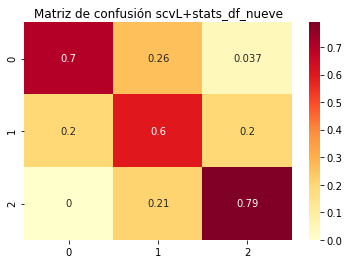

model RF
              precision    recall  f1-score    support
0              0.750000  0.888889  0.813559  27.000000
1              0.500000  0.400000  0.444444   5.000000
2              0.800000  0.631579  0.705882  19.000000
accuracy       0.745098  0.745098  0.745098   0.745098
macro avg      0.683333  0.640156  0.654629  51.000000
weighted avg   0.744118  0.745098  0.737257  51.000000


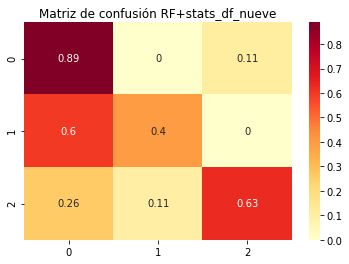

datarame N°: stats_df_ocho.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.757576  0.925926  0.833333  27.000000
1              0.666667  0.400000  0.500000   5.000000
2              0.933333  0.736842  0.823529  19.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.785859  0.687589  0.718954  51.000000
weighted avg   0.814141  0.803922  0.797001  51.000000


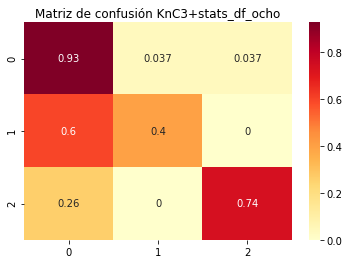

model scvL
              precision    recall  f1-score    support
0              0.954545  0.777778  0.857143  27.000000
1              0.333333  0.800000  0.470588   5.000000
2              0.941176  0.842105  0.888889  19.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.743018  0.806628  0.738873  51.000000
weighted avg   0.888662  0.803922  0.831072  51.000000


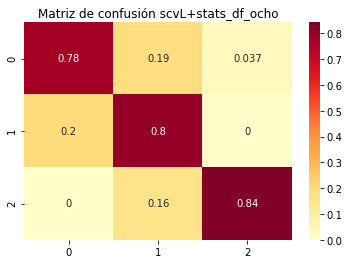

model RF
              precision    recall  f1-score    support
0              0.866667  0.962963  0.912281  27.000000
1              0.750000  0.600000  0.666667   5.000000
2              1.000000  0.894737  0.944444  19.000000
accuracy       0.901961  0.901961  0.901961   0.901961
macro avg      0.872222  0.819233  0.841131  51.000000
weighted avg   0.904902  0.901961  0.900183  51.000000


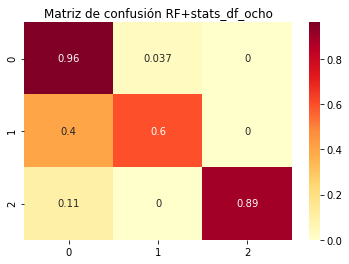

datarame N°: stats_df_seis.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.833333  0.925926  0.877193  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.842105  0.842105  0.842105  19.000000
accuracy       0.843137  0.843137  0.843137   0.843137
macro avg      0.891813  0.722677  0.763576  51.000000
weighted avg   0.852941  0.843137  0.834144  51.000000


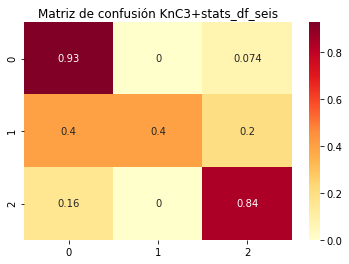

model scvL
              precision    recall  f1-score    support
0              0.925926  0.925926  0.925926  27.000000
1              0.375000  0.600000  0.461538   5.000000
2              0.937500  0.789474  0.857143  19.000000
accuracy       0.843137  0.843137  0.843137   0.843137
macro avg      0.746142  0.771800  0.748202  51.000000
weighted avg   0.876225  0.843137  0.854773  51.000000


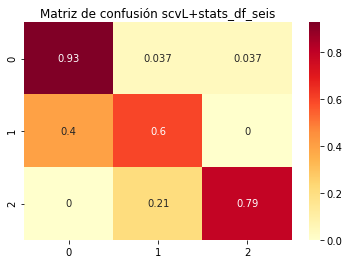

model RF
              precision    recall  f1-score    support
0              0.838710  0.962963  0.896552  27.000000
1              0.750000  0.600000  0.666667   5.000000
2              1.000000  0.842105  0.914286  19.000000
accuracy       0.882353  0.882353  0.882353   0.882353
macro avg      0.862903  0.801689  0.825835  51.000000
weighted avg   0.890101  0.882353  0.880621  51.000000


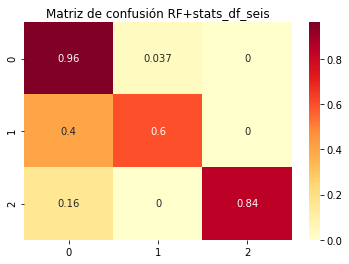

datarame N°: stats_df_siete.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.866667  0.962963  0.912281  27.000000
1              1.000000  0.600000  0.750000   5.000000
2              0.944444  0.894737  0.918919  19.000000
accuracy       0.901961  0.901961  0.901961   0.901961
macro avg      0.937037  0.819233  0.860400  51.000000
weighted avg   0.908715  0.901961  0.898844  51.000000


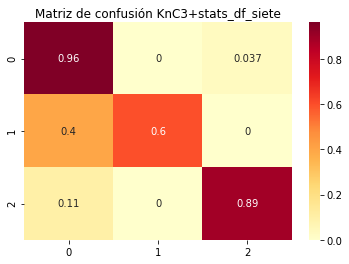

model scvL
              precision    recall  f1-score    support
0              0.925926  0.925926  0.925926  27.000000
1              0.333333  0.400000  0.363636   5.000000
2              0.888889  0.842105  0.864865  19.000000
accuracy       0.843137  0.843137  0.843137   0.843137
macro avg      0.716049  0.722677  0.718142  51.000000
weighted avg   0.854031  0.843137  0.848051  51.000000


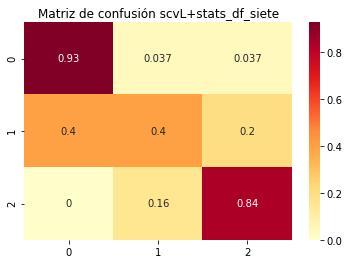

model RF
              precision    recall  f1-score    support
0              0.870968  1.000000  0.931034  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.944444  0.894737  0.918919  19.000000
accuracy       0.901961  0.901961  0.901961   0.901961
macro avg      0.938471  0.764912  0.807127  51.000000
weighted avg   0.910992  0.901961  0.891265  51.000000


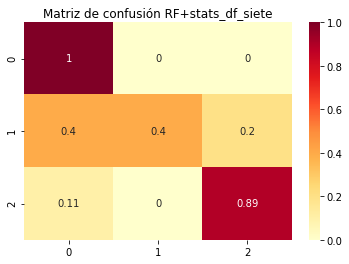

datarame N°: stats_df_tres.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.812500  0.962963  0.881356  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.882353  0.789474  0.833333  19.000000
accuracy       0.843137  0.843137  0.843137   0.843137
macro avg      0.898284  0.717479  0.762039  51.000000
weighted avg   0.856906  0.843137  0.833080  51.000000


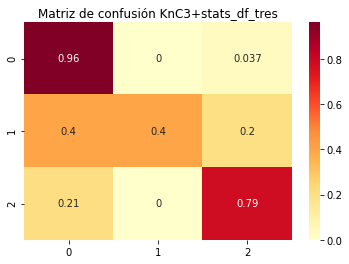

model scvL
              precision    recall  f1-score    support
0              0.913043  0.777778  0.840000  27.000000
1              0.272727  0.600000  0.375000   5.000000
2              0.941176  0.842105  0.888889  19.000000
accuracy       0.784314  0.784314  0.784314   0.784314
macro avg      0.708982  0.739961  0.701296  51.000000
weighted avg   0.860748  0.784314  0.812625  51.000000


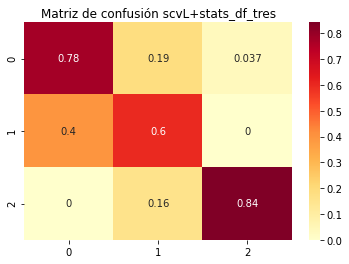

model RF
              precision    recall  f1-score    support
0              0.843750  1.000000  0.915254  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.941176  0.842105  0.888889  19.000000
accuracy       0.882353  0.882353  0.882353   0.882353
macro avg      0.928309  0.747368  0.791857  51.000000
weighted avg   0.895365  0.882353  0.871723  51.000000


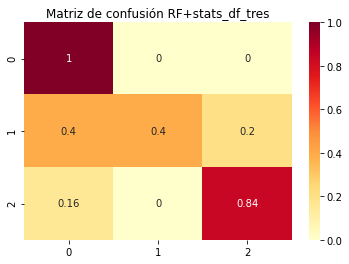

datarame N°: stats_df_uno.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.812500  0.962963  0.881356  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.882353  0.789474  0.833333  19.000000
accuracy       0.843137  0.843137  0.843137   0.843137
macro avg      0.898284  0.717479  0.762039  51.000000
weighted avg   0.856906  0.843137  0.833080  51.000000


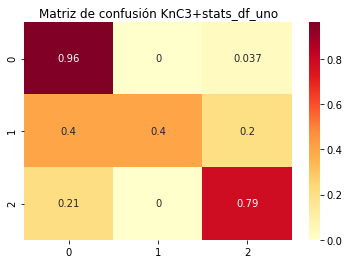

model scvL
              precision    recall  f1-score    support
0              0.916667  0.814815  0.862745  27.000000
1              0.300000  0.600000  0.400000   5.000000
2              0.941176  0.842105  0.888889  19.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.719281  0.752307  0.717211  51.000000
weighted avg   0.865340  0.803922  0.827118  51.000000


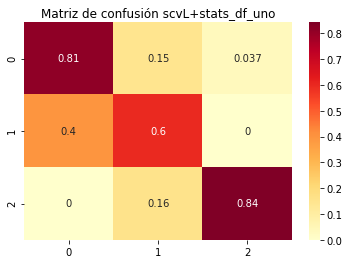

model RF
              precision    recall  f1-score    support
0              0.843750  1.000000  0.915254  27.000000
1              1.000000  0.400000  0.571429   5.000000
2              0.941176  0.842105  0.888889  19.000000
accuracy       0.882353  0.882353  0.882353   0.882353
macro avg      0.928309  0.747368  0.791857  51.000000
weighted avg   0.895365  0.882353  0.871723  51.000000


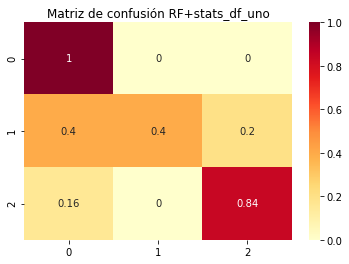

datarame N°: wave_df_cinco.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.714286  0.925926  0.806452  27.000000
1              1.000000  0.200000  0.333333   5.000000
2              0.866667  0.684211  0.764706  19.000000
accuracy       0.764706  0.764706  0.764706   0.764706
macro avg      0.860317  0.603379  0.634830  51.000000
weighted avg   0.799066  0.764706  0.744515  51.000000


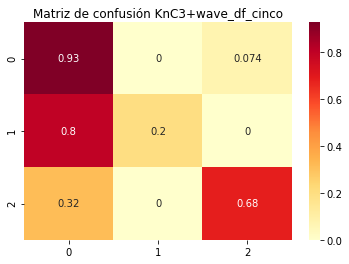

model scvL
              precision    recall  f1-score    support
0              0.916667  0.814815  0.862745  27.000000
1              0.200000  0.600000  0.300000   5.000000
2              0.833333  0.526316  0.645161  19.000000
accuracy       0.686275  0.686275  0.686275   0.686275
macro avg      0.650000  0.647044  0.602635  51.000000
weighted avg   0.815359  0.686275  0.726513  51.000000


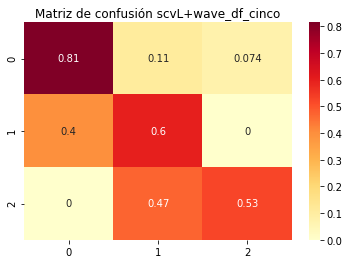

model RF
              precision    recall  f1-score    support
0              0.812500  0.962963  0.881356  27.000000
1              0.750000  0.600000  0.666667   5.000000
2              0.933333  0.736842  0.823529  19.000000
accuracy       0.843137  0.843137  0.843137   0.843137
macro avg      0.831944  0.766602  0.790517  51.000000
weighted avg   0.851389  0.843137  0.838765  51.000000


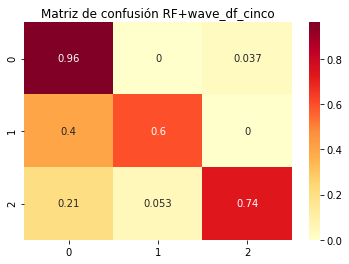

datarame N°: wave_df_cuatro.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.793103  0.851852  0.821429  27.000000
1              1.000000  0.200000  0.333333   5.000000
2              0.809524  0.894737  0.850000  19.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.867542  0.648863  0.668254  51.000000
weighted avg   0.819505  0.803922  0.784220  51.000000


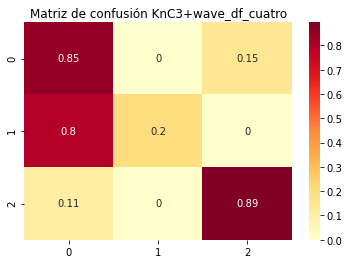

model scvL
              precision    recall  f1-score    support
0              0.884615  0.851852  0.867925  27.000000
1              0.133333  0.400000  0.200000   5.000000
2              0.800000  0.421053  0.551724  19.000000
accuracy       0.647059  0.647059  0.647059   0.647059
macro avg      0.605983  0.557635  0.539883  51.000000
weighted avg   0.779437  0.647059  0.684642  51.000000


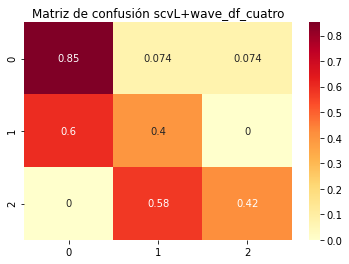

model RF
              precision    recall  f1-score    support
0              0.896552  0.962963  0.928571  27.000000
1              1.000000  0.600000  0.750000   5.000000
2              0.947368  0.947368  0.947368  19.000000
accuracy       0.921569  0.921569  0.921569   0.921569
macro avg      0.947973  0.836777  0.875313  51.000000
weighted avg   0.925625  0.921569  0.918067  51.000000


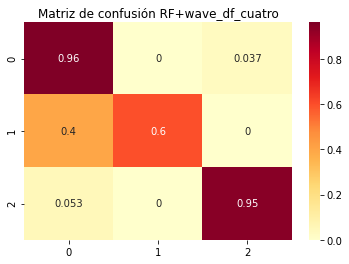

datarame N°: wave_df_dos.xlsx
model KnC3
              precision    recall  f1-score   support
0              0.727273  0.888889  0.800000  27.00000
1              0.333333  0.200000  0.250000   5.00000
2              0.800000  0.631579  0.705882  19.00000
accuracy       0.725490  0.725490  0.725490   0.72549
macro avg      0.620202  0.573489  0.585294  51.00000
weighted avg   0.715746  0.725490  0.711015  51.00000


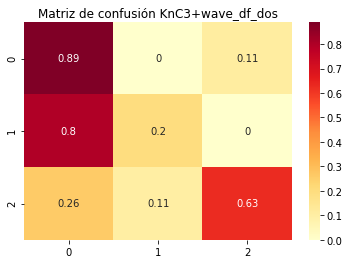

model scvL
              precision    recall  f1-score    support
0              0.925926  0.925926  0.925926  27.000000
1              0.300000  0.600000  0.400000   5.000000
2              0.928571  0.684211  0.787879  19.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.718166  0.736712  0.704602  51.000000
weighted avg   0.865546  0.803922  0.822935  51.000000


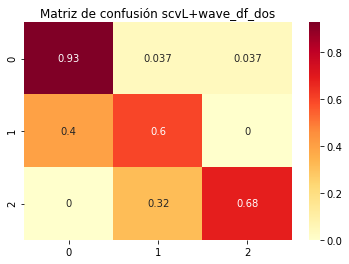

model RF
              precision    recall  f1-score    support
0              0.838710  0.962963  0.896552  27.000000
1              1.000000  0.200000  0.333333   5.000000
2              0.894737  0.894737  0.894737  19.000000
accuracy       0.862745  0.862745  0.862745   0.862745
macro avg      0.911149  0.685900  0.708207  51.000000
weighted avg   0.875395  0.862745  0.840658  51.000000


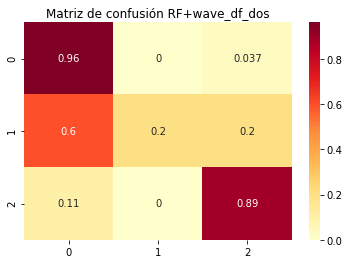

datarame N°: wave_df_ocho.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.718750  0.851852  0.779661  27.000000
1              0.200000  0.200000  0.200000   5.000000
2              0.785714  0.578947  0.666667  19.000000
accuracy       0.686275  0.686275  0.686275   0.686275
macro avg      0.568155  0.543600  0.548776  51.000000
weighted avg   0.692840  0.686275  0.680736  51.000000


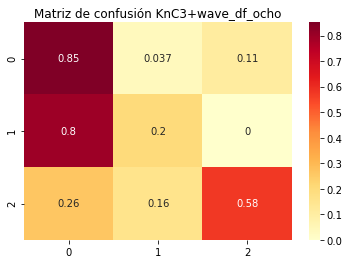

model scvL
              precision    recall  f1-score    support
0              0.740741  0.740741  0.740741  27.000000
1              0.222222  0.400000  0.285714   5.000000
2              0.600000  0.473684  0.529412  19.000000
accuracy       0.607843  0.607843  0.607843   0.607843
macro avg      0.520988  0.538142  0.518622  51.000000
weighted avg   0.637473  0.607843  0.617400  51.000000


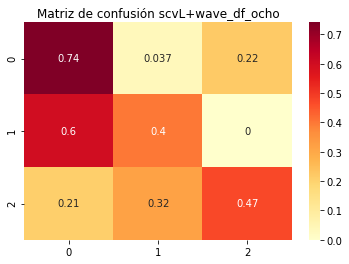

model RF
              precision    recall  f1-score   support
0              0.750000  0.777778  0.763636  27.00000
1              0.500000  0.400000  0.444444   5.00000
2              0.736842  0.736842  0.736842  19.00000
accuracy       0.725490  0.725490  0.725490   0.72549
macro avg      0.662281  0.638207  0.648308  51.00000
weighted avg   0.720588  0.725490  0.722361  51.00000


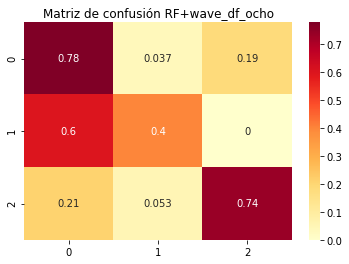

datarame N°: wave_df_seis.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.806452  0.925926  0.862069  27.000000
1              0.666667  0.400000  0.500000   5.000000
2              0.882353  0.789474  0.833333  19.000000
accuracy       0.823529  0.823529  0.823529   0.823529
macro avg      0.785157  0.705133  0.731801  51.000000
weighted avg   0.821024  0.823529  0.815867  51.000000


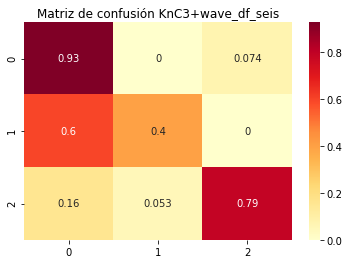

model scvL
              precision    recall  f1-score    support
0              0.833333  0.925926  0.877193  27.000000
1              0.000000  0.000000  0.000000   5.000000
2              0.800000  0.842105  0.820513  19.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.544444  0.589344  0.565902  51.000000
weighted avg   0.739216  0.803922  0.770078  51.000000


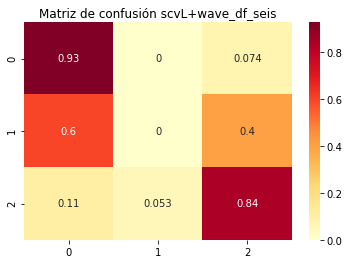

model RF
              precision    recall  f1-score    support
0              0.896552  0.962963  0.928571  27.000000
1              0.666667  0.400000  0.500000   5.000000
2              0.947368  0.947368  0.947368  19.000000
accuracy       0.901961  0.901961  0.901961   0.901961
macro avg      0.836862  0.770110  0.791980  51.000000
weighted avg   0.892946  0.901961  0.893557  51.000000


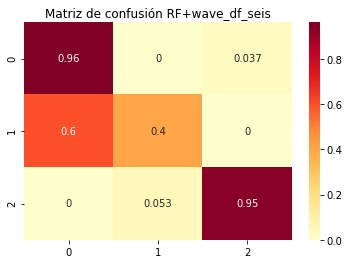

datarame N°: wave_df_siete.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.764706  0.962963  0.852459  27.000000
1              0.500000  0.200000  0.285714   5.000000
2              0.866667  0.684211  0.764706  19.000000
accuracy       0.784314  0.784314  0.784314   0.784314
macro avg      0.710458  0.615724  0.634293  51.000000
weighted avg   0.776740  0.784314  0.764203  51.000000


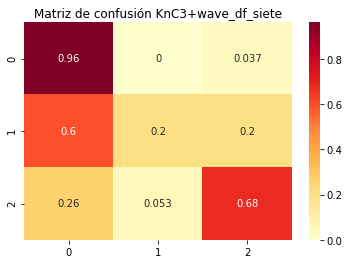

model scvL
              precision    recall  f1-score    support
0              0.923077  0.888889  0.905660  27.000000
1              0.133333  0.400000  0.200000   5.000000
2              0.900000  0.473684  0.620690  19.000000
accuracy       0.686275  0.686275  0.686275   0.686275
macro avg      0.652137  0.587524  0.575450  51.000000
weighted avg   0.837054  0.686275  0.730312  51.000000


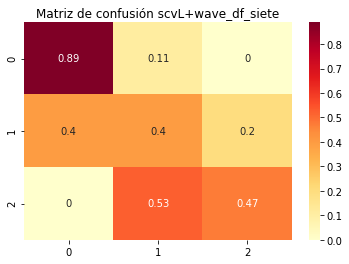

model RF
              precision    recall  f1-score    support
0              0.928571  0.962963  0.945455  27.000000
1              0.600000  0.600000  0.600000   5.000000
2              0.944444  0.894737  0.918919  19.000000
accuracy       0.901961  0.901961  0.901961   0.901961
macro avg      0.824339  0.819233  0.821458  51.000000
weighted avg   0.902272  0.901961  0.901701  51.000000


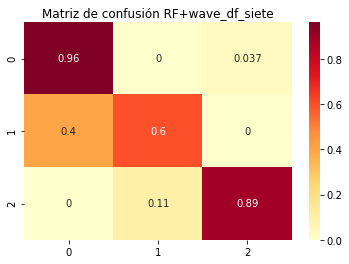

datarame N°: wave_df_tres.xlsx
model KnC3
              precision    recall  f1-score    support
0              0.800000  0.888889  0.842105  27.000000
1              0.666667  0.400000  0.500000   5.000000
2              0.888889  0.842105  0.864865  19.000000
accuracy       0.823529  0.823529  0.823529   0.823529
macro avg      0.785185  0.710331  0.735657  51.000000
weighted avg   0.820044  0.823529  0.817045  51.000000


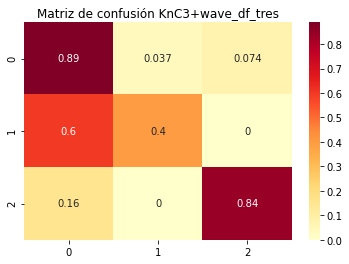

model scvL
              precision    recall  f1-score   support
0              0.833333  0.740741  0.784314  27.00000
1              0.333333  0.800000  0.470588   5.00000
2              0.866667  0.684211  0.764706  19.00000
accuracy       0.725490  0.725490  0.725490   0.72549
macro avg      0.677778  0.741650  0.673203  51.00000
weighted avg   0.796732  0.725490  0.746251  51.00000


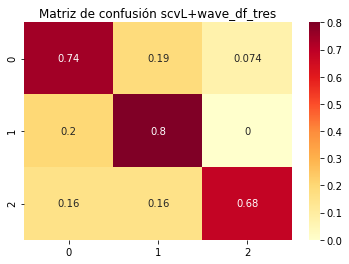

model RF
              precision    recall  f1-score    support
0              0.866667  0.962963  0.912281  27.000000
1              1.000000  0.600000  0.750000   5.000000
2              0.944444  0.894737  0.918919  19.000000
accuracy       0.901961  0.901961  0.901961   0.901961
macro avg      0.937037  0.819233  0.860400  51.000000
weighted avg   0.908715  0.901961  0.898844  51.000000


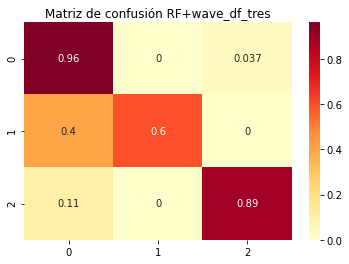

datarame N°: wave_df_uno.xlsx
model KnC3
              precision    recall  f1-score   support
0              0.718750  0.851852  0.779661  27.00000
1              0.666667  0.400000  0.500000   5.00000
2              0.750000  0.631579  0.685714  19.00000
accuracy       0.725490  0.725490  0.725490   0.72549
macro avg      0.711806  0.627810  0.655125  51.00000
weighted avg   0.725286  0.725490  0.717244  51.00000


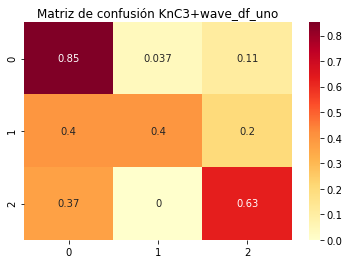

model scvL
              precision    recall  f1-score    support
0              0.954545  0.777778  0.857143  27.000000
1              0.416667  1.000000  0.588235   5.000000
2              0.882353  0.789474  0.833333  19.000000
accuracy       0.803922  0.803922  0.803922   0.803922
macro avg      0.751188  0.855750  0.759570  51.000000
weighted avg   0.874917  0.803922  0.821909  51.000000


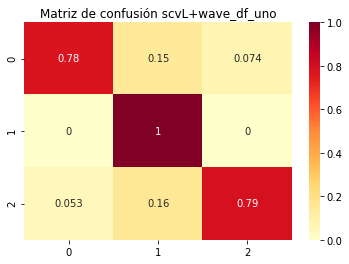

model RF
              precision    recall  f1-score    support
0              0.862069  0.925926  0.892857  27.000000
1              0.750000  0.600000  0.666667   5.000000
2              0.888889  0.842105  0.864865  19.000000
accuracy       0.862745  0.862745  0.862745   0.862745
macro avg      0.833653  0.789344  0.808130  51.000000
weighted avg   0.861074  0.862745  0.860253  51.000000


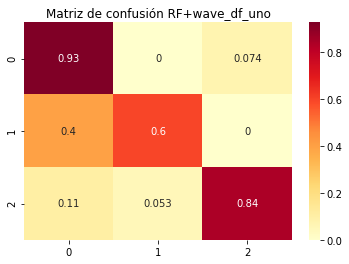

In [11]:
model_supervised_dict = {"KnC3":kn3,"scvL":linear_svc,"RF":rforest}
trained_models_sup_dict = {}
n_models_sup=len(model_supervised_dict)

score_sup= pd.DataFrame()

for fila in range (len(list_df)):
    df_name = list_df[fila][1]
    print("datarame N°:", df_name)   
    df_name=list_df[fila][1]
    df_name=df_name.split(".")[0]
    sub_dict = {} #sub dict va a llenarse de modelos entrenados 
    for model in model_supervised_dict.keys():
        print("model", model)
        each_df= pd.read_excel(main_path+"/"+list_df[fila][1], index_col=0)
        #print(each_df)
        
        sub_dict[model] = supervised_training_models(each_df,score_sup, model_supervised_dict[model],str(model),str(df_name))
        
    trained_models_sup_dict[list_df[fila][1]] = sub_dict

In [12]:
score_unsup

KmC4      KmC3
df_mix_dos       0.621161  0.617991
df_mix_uno       0.622218  0.605100
stats_df_cinco   0.595590  0.578684
stats_df_cuatro  0.610101  0.605100
stats_df_diez    0.595520  0.575655
stats_df_dos     0.621161  0.612919
stats_df_nueve   0.624190  0.596506
stats_df_ocho    0.606157  0.579670
stats_df_seis    0.622852  0.571217
stats_df_siete   0.645041  0.663145
stats_df_tres    0.610031  0.592984
stats_df_uno     0.589955  0.600873
wave_df_cinco    0.643702  0.658495
wave_df_cuatro   0.650113  0.650042
wave_df_dos      0.580657  0.621372
wave_df_ocho     0.595661  0.603480
wave_df_seis     0.582981  0.600099
wave_df_siete    0.564877  0.633066
wave_df_tres     0.567484  0.618555
wave_df_uno      0.581361  0.594745

In [13]:
score_sup

KnC3      scvL        RF
df_mix_dos       0.792815  0.701286  0.890114
df_mix_uno       0.759049  0.703801  0.875160
stats_df_cinco   0.631954  0.701296  0.805051
stats_df_cuatro  0.777615  0.737006  0.807127
stats_df_diez    0.598413  0.641176  0.719865
stats_df_dos     0.777615  0.734025  0.807127
stats_df_nueve   0.548048  0.652544  0.654629
stats_df_ocho    0.718954  0.738873  0.841131
stats_df_seis    0.763576  0.748202  0.825835
stats_df_siete   0.860400  0.718142  0.807127
stats_df_tres    0.762039  0.701296  0.791857
stats_df_uno     0.762039  0.717211  0.791857
wave_df_cinco    0.634830  0.602635  0.790517
wave_df_cuatro   0.668254  0.539883  0.875313
wave_df_dos      0.585294  0.704602  0.708207
wave_df_ocho     0.548776  0.518622  0.648308
wave_df_seis     0.731801  0.565902  0.791980
wave_df_siete    0.634293  0.575450  0.821458
wave_df_tres     0.735657  0.673203  0.860400
wave_df_uno      0.655125  0.759570  0.808130

In [14]:
with pd.ExcelWriter('Comparacion Score_3.xlsx', mode="a", engine="openpyxl") as writer: 
    score_sup.to_excel(writer, sheet_name= "score_sup" )
    score_unsup.to_excel(writer, sheet_name= "score_unsup" )
    
    